# 1일 후의 하수처리량 예측 모델링
---
### 무엇을? 
- 1일 후의 하수처리량

### 어떻게? 
- 파생변수 추가
- EDA 간단하게 다시 진행
- 모델에 쓰지 않을 컬럼 제거
- 모델 학습, 학습 결과 비교
- 10단계 다중분류 센터별로

### 왜?
- 오늘까지의 정보를 기반으로 내일의 하수처리량을 예측하여 필요한 에너지, 자원 등을 더욱 효율적으로 사용할 수 있는 근거를 마련하고자 함

### 어떤 모델을?
1. 회귀 모델
2. LSTM, GRU
3. TabNet

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# 한글 폰트 설정
# plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
plt.rcParams['font.family'] ='AppleGothic' # 맥
# 맥, 윈도우 중 가능한거로
# plt.rcParams['font.family'] = ['AppleGothic', 'Malgun Gothic', 'NanumGothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

### 파생변수
- 날짜 파생 
    - 트리 계열(랜덤포레스트/LightGBM/XGBoost): 
        - 월=1..12 같은 정수도 꽤 잘 다루지만, **12↔1의 연속성(원형성)**은 못 느낌
        - 그래서 12월과 1월이 멀리 떨어진 값으로 인식될 수 있음
        - = sin/cos로 순환 인코딩하면 월말->월초 경계가 매끄럽게 이어져서 보통 소폭이라도 좋아짐
    - 선형/신경망 계열(선형회귀, Lasso/Ridge, MLP, LSTM 등): 
        - 수치 자체의 순서에 민감해서, sin/cos 순환 인코딩이 거의 필수
        - 또한 요일 효과가 약해도, 월/연간 계절성은 강했으니, 최소한 월/연간(일-오브-이어) 주기는 sin/cos로 쓰는 게 이득일 가능성이 큼
        - 연은 추세 성격이라 **그냥 숫자(또는 표준화)**로 두는 게 보통 더 ㄱㅊ

==> 기존에 EDA 하면서 추가한 파생변수에서 수정

In [161]:
nanji = pd.read_csv('../data/processed/center_season/nanji/난지_merged.csv', encoding='utf-8-sig')
# nanji = pd.read_csv('../data/processed/center_season/nanji/nanji_for_eda.csv', encoding='utf-8-sig')
jungnang = pd.read_csv('../data/processed/center_season/jungnang/중랑_merged.csv', encoding='utf-8-sig')
seonam = pd.read_csv('../data/processed/center_season/seonam/서남_merged.csv', encoding='utf-8-sig')
tancheon = pd.read_csv('../data/processed/center_season/tancheon/탄천_merged.csv', encoding='utf-8-sig')

print(nanji.info())
print(jungnang.info())
print(seonam.info())
print(tancheon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3103 entries, 0 to 3102
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   날짜             3103 non-null   object 
 1   요일             3103 non-null   object 
 2   공휴일            3103 non-null   int64  
 3   목욕장업           3103 non-null   int64  
 4   세탁업            3103 non-null   int64  
 5   수영장업           3103 non-null   int64  
 6   종합체육시설업        3103 non-null   int64  
 7   체력단련장업         3103 non-null   int64  
 8   하천             3103 non-null   float64
 9   생활인구           3103 non-null   float64
 10  불쾌지수(DI)       3103 non-null   float64
 11  불쾌지수등급         3103 non-null   object 
 12  일_일강수량(mm)     3103 non-null   float64
 13  일_최저기온(°C)     3103 non-null   float64
 14  일_평균기온(°C)     3103 non-null   float64
 15  일_최고기온(°C)     3103 non-null   float64
 16  일_평균풍속(m/s)    3103 non-null   float64
 17  일_최대순간풍속(m/s)  3103 non-null   float64
 18  최저습도(%) 

In [162]:
'''# 안전: 날짜 정렬ㅁ
nanji['날짜'] = pd.to_datetime(nanji['날짜'])
nanji = nanji.sort_values('날짜').reset_index(drop=True)
# 난지 6월 데이터 없음 -> 다 0으로 되어 있으니까 제거 
nanji = nanji[nanji["날짜"] < "2025-06-01"] 

# 날짜 파생 (순환 인코딩)
def add_cyclical_features(df, date_col='날짜'):
    d = df[date_col].dt

    # 월
    df['월_sin'] = np.sin(2*np.pi*d.month/12)
    df['월_cos'] = np.cos(2*np.pi*d.month/12)

    # 요일
    dow = d.weekday
    df['요일_sin'] = np.sin(2*np.pi*dow/7)
    df['요일_cos'] = np.cos(2*np.pi*dow/7)

    # 연중일
    doy = d.dayofyear
    df['연중일_sin'] = np.sin(2*np.pi*doy/365.25)
    df['연중일_cos'] = np.cos(2*np.pi*doy/365.25)
    return df

nanji = add_cyclical_features(nanji)

# 라그 (lag) : 과거 값
add_lag_specs = {
    '일_평균기온(°C)': [1, 3],
    '일_최고기온(°C)': [1, 3],
    '일_최저기온(°C)': [1, 3],
    '평균습도(%)': [1, 3],
    '불쾌지수(DI)': [1, 3],
    '하천': [1, 3],
    '일_평균풍속(m/s)': [1],  # 영향 약할 수 있어 가볍게
    '합계': [1,3,7],
    '생활인구': [1,3,7],
    '일_일강수량(mm)': [1,3],
}
for col, lags in add_lag_specs.items():
    for L in lags:
        nanji[f'{col}_lag{L}'] = nanji[col].shift(L)

# 롤링 (오늘까지) : 누적값
nanji['합계_roll7_mean'] = nanji['합계'].rolling(7, min_periods=1).mean()
nanji['합계_roll7_std']  = nanji['합계'].rolling(7, min_periods=2).std()
nanji['생활인구_roll7_mean'] = nanji['생활인구'].rolling(7, min_periods=1).mean()
nanji['강수량_roll3_sum'] = nanji['일_일강수량(mm)'].rolling(3, min_periods=1).sum()
nanji['강수량_roll7_sum'] = nanji['일_일강수량(mm)'].rolling(7, min_periods=1).sum()

# 변화율/증감
'''
# nanji['합계_전일증감률']    = nanji['합계'].pct_change()
# nanji['합계_전일변화']      = nanji['합계'].diff()
# nanji['생활인구_전일증감률'] = nanji['생활인구'].pct_change()
# nanji['강수량_전일변화']    = nanji['일_일강수량(mm)'].diff()
'''

# 날씨/이벤트
nanji['일교차']   = nanji['일_최고기온(°C)'] - nanji['일_최저기온(°C)']
nanji['체감온도'] = nanji['일_평균기온(°C)'] - 0.7*nanji['일_평균풍속(m/s)']
nanji['습도차이'] = nanji['최고습도(%)'] - nanji['최저습도(%)']

nanji['강수_여부'] = (nanji['일_일강수량(mm)'] > 0).astype(int)
nanji['폭우_여부'] = (nanji['일_일강수량(mm)'] >= 80).astype(int)
nanji['폭염일']    = (nanji['일_최고기온(°C)'] >= 33).astype(int)
# nanji['한파_여부'] = (nanji['일_최저기온(°C)'] <= -12).astype(int)

# 인허가 파생
# nanji['인허가'] = nanji[['목욕장업','세탁업','수영장업','종합체육시설업','체력단련장업']].sum(axis=1)

# 타깃 생성
nanji['합계_1일후'] = nanji['합계'].shift(-1)
nanji['합계_2일후'] = nanji['합계'].shift(-2)

# 요일 숫자로
nanji['요일_숫자'] = nanji['날짜'].dt.weekday # 0:월요일, 1:화요일, ... , 6:일요일

# 계절, 불쾌지수등급 숫자로
nanji = nanji.replace(
    {
        '계절': {'봄': 0, '여름' : 1, '가을' : 2, '겨울' : 3},
        '불쾌지수등급' : {'쾌적' : 0, '약간 불쾌' : 1, '불쾌' : 2, '매우 불쾌' : 3, '극심한 불쾌' : 4}
     })



nanji.columns
'''

"\n\n# 날씨/이벤트\nnanji['일교차']   = nanji['일_최고기온(°C)'] - nanji['일_최저기온(°C)']\nnanji['체감온도'] = nanji['일_평균기온(°C)'] - 0.7*nanji['일_평균풍속(m/s)']\nnanji['습도차이'] = nanji['최고습도(%)'] - nanji['최저습도(%)']\n\nnanji['강수_여부'] = (nanji['일_일강수량(mm)'] > 0).astype(int)\nnanji['폭우_여부'] = (nanji['일_일강수량(mm)'] >= 80).astype(int)\nnanji['폭염일']    = (nanji['일_최고기온(°C)'] >= 33).astype(int)\n# nanji['한파_여부'] = (nanji['일_최저기온(°C)'] <= -12).astype(int)\n\n# 인허가 파생\n# nanji['인허가'] = nanji[['목욕장업','세탁업','수영장업','종합체육시설업','체력단련장업']].sum(axis=1)\n\n# 타깃 생성\nnanji['합계_1일후'] = nanji['합계'].shift(-1)\nnanji['합계_2일후'] = nanji['합계'].shift(-2)\n\n# 요일 숫자로\nnanji['요일_숫자'] = nanji['날짜'].dt.weekday # 0:월요일, 1:화요일, ... , 6:일요일\n\n# 계절, 불쾌지수등급 숫자로\nnanji = nanji.replace(\n    {\n        '계절': {'봄': 0, '여름' : 1, '가을' : 2, '겨울' : 3},\n        '불쾌지수등급' : {'쾌적' : 0, '약간 불쾌' : 1, '불쾌' : 2, '매우 불쾌' : 3, '극심한 불쾌' : 4}\n     })\n\n\n\nnanji.columns\n"

In [163]:
def make_features(df):
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜').reset_index(drop=True)
    # 난지, 서남 6월 데이터 없음 -> 다 0으로 되어 있으니까 제거 
    df = df[df["날짜"] < "2025-06-01"] 

    df['월'] = df['날짜'].dt.month #월
    df['요일_숫자'] = df['날짜'].dt.weekday # 0:월요일, 1:화요일, ... , 6:일요일 -> 요일 숫자로

    # 계절, 불쾌지수등급 숫자로
    season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
    discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
    df['계절'] = df['계절'].map(season_map).astype('Int64')
    df['불쾌지수등급'] = df['불쾌지수등급'].map(discomfort_map).astype('Int64')

    df['강수량_1일전'] = df['일_일강수량(mm)'].shift(1)
    df['강수량_2일전'] = df['일_일강수량(mm)'].shift(2)

    # 타겟
    df['합계_1일후'] = df['합계'].shift(-1)
    df['합계_2일후'] = df['합계'].shift(-2)
    
    df = df.dropna().reset_index(drop=True)
    
    return df

nanji = make_features(nanji)
jungnang = make_features(jungnang)
seonam = make_features(seonam)
tancheon = make_features(tancheon)


'''
nanji['날짜'] = pd.to_datetime(nanji['날짜'])
nanji = nanji.sort_values('날짜').reset_index(drop=True)
# 난지 6월 데이터 없음 -> 다 0으로 되어 있으니까 제거 
nanji = nanji[nanji["날짜"] < "2025-06-01"] 

nanji['월'] = nanji['날짜'].dt.month #월
nanji['요일_숫자'] = nanji['날짜'].dt.weekday # 0:월요일, 1:화요일, ... , 6:일요일 -> 요일 숫자로

# 계절, 불쾌지수등급 숫자로
season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
nanji['계절'] = nanji['계절'].map(season_map).astype('Int64')
nanji['불쾌지수등급'] = nanji['불쾌지수등급'].map(discomfort_map).astype('Int64')

nanji['강수량_1일전'] = nanji['일_일강수량(mm)'].shift(1)
nanji['강수량_2일전'] = nanji['일_일강수량(mm)'].shift(2)

# 타겟
nanji['합계_1일후'] = nanji['합계'].shift(-1)
nanji['합계_2일후'] = nanji['합계'].shift(-2)
'''

'\nnanji[\'날짜\'] = pd.to_datetime(nanji[\'날짜\'])\nnanji = nanji.sort_values(\'날짜\').reset_index(drop=True)\n# 난지 6월 데이터 없음 -> 다 0으로 되어 있으니까 제거 \nnanji = nanji[nanji["날짜"] < "2025-06-01"] \n\nnanji[\'월\'] = nanji[\'날짜\'].dt.month #월\nnanji[\'요일_숫자\'] = nanji[\'날짜\'].dt.weekday # 0:월요일, 1:화요일, ... , 6:일요일 -> 요일 숫자로\n\n# 계절, 불쾌지수등급 숫자로\nseason_map = {\'봄\': 0, \'여름\': 1, \'가을\': 2, \'겨울\': 3}\ndiscomfort_map = {\'쾌적\': 0, \'약간 불쾌\': 1, \'불쾌\': 2, \'매우 불쾌\': 3, \'극심한 불쾌\': 4}\nnanji[\'계절\'] = nanji[\'계절\'].map(season_map).astype(\'Int64\')\nnanji[\'불쾌지수등급\'] = nanji[\'불쾌지수등급\'].map(discomfort_map).astype(\'Int64\')\n\nnanji[\'강수량_1일전\'] = nanji[\'일_일강수량(mm)\'].shift(1)\nnanji[\'강수량_2일전\'] = nanji[\'일_일강수량(mm)\'].shift(2)\n\n# 타겟\nnanji[\'합계_1일후\'] = nanji[\'합계\'].shift(-1)\nnanji[\'합계_2일후\'] = nanji[\'합계\'].shift(-2)\n'

In [ ]:
# 널 값 다 제대로 처리되었는지 확인
print(nanji.isnull().sum()[nanji.isnull().sum() > 0])
print(seonam.isnull().sum()[seonam.isnull().sum() > 0])
print(jungnang.isnull().sum()[jungnang.isnull().sum() > 0])
print(tancheon.isnull().sum()[tancheon.isnull().sum() > 0])

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


In [166]:
jungnang.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   날짜             3069 non-null   datetime64[ns]
 1   요일             3069 non-null   object        
 2   공휴일            3069 non-null   int64         
 3   목욕장업           3069 non-null   int64         
 4   세탁업            3069 non-null   int64         
 5   수영장업           3069 non-null   int64         
 6   종합체육시설업        3069 non-null   int64         
 7   체력단련장업         3069 non-null   int64         
 8   하천             3069 non-null   float64       
 9   생활인구           3069 non-null   float64       
 10  불쾌지수(DI)       3069 non-null   float64       
 11  불쾌지수등급         3069 non-null   Int64         
 12  일_일강수량(mm)     3069 non-null   float64       
 13  일_최저기온(°C)     3069 non-null   float64       
 14  일_평균기온(°C)     3069 non-null   float64       
 15  일_최고기온(°C)     3069 n

In [118]:
nanji.columns

Index(['날짜', '요일', '공휴일', '목욕장업', '세탁업', '수영장업', '종합체육시설업', '체력단련장업', '하천',
       '생활인구', '불쾌지수(DI)', '불쾌지수등급', '일_일강수량(mm)', '일_최저기온(°C)', '일_평균기온(°C)',
       '일_최고기온(°C)', '일_평균풍속(m/s)', '일_최대순간풍속(m/s)', '최저습도(%)', '평균습도(%)',
       '최고습도(%)', '습도표준편차', '1처리장', '2처리장', '정화조', '중계펌프장', '합계', '계절', '월',
       '요일_숫자', '강수량_1일전', '강수량_2일전', '합계_1일후', '합계_2일후'],
      dtype='object')

In [119]:
# 학습에 사용하지 않을 컬럼
'''
목표: y_{t+1} = 내일 하수처리량
사용 가능한 정보: 시점 t (오늘까지) 의 관측값
사용하면 안 되는 정보: 시점 t+1 (내일 이후) 의 관측값
'''
not_use_col = [
    # 날짜 원본
    '날짜', 
    # 범주형 컬럼
    '요일',
    # 1일 후 합계에 직접적인 영향을 주는 값
    '1처리장', '2처리장', '정화조', '중계펌프장',
    # 원본 데이터를 직접 사용하는 것보다 lag, rolling 값 사용이 더 안전할수도?
    #'일_일강수량(mm)', '생활인구',
    # 타겟값
    '합계_1일후', '합계_2일후'
]



### 모델링 - 당일 합계

In [120]:
TARGET = '합계'
not_use_col = [
    '날짜',         # 날짜 원본 (순환 인코딩 피처로 대체)
    '요일',         # 원본 요일 컬럼 (존재할 경우 제거)
    '1처리장', '2처리장', '정화조', '중계펌프장',        # 타겟 변수와 강한 상관관계, 정보 누수 위험
    '합계',
    '합계_1일후',    # 타겟 변수
    '합계_2일후',    # 미래 정보
]

# nanji 데이터프레임에 존재하지 않는 컬럼은 not_use_col 리스트에서 제외
not_use_col = [col for col in not_use_col if col in nanji.columns]

# 위 변수들을 제외한 모든 변수를 피처로 사용
features = [col for col in nanji.columns if col not in not_use_col]

y = nanji[TARGET]
X = nanji[features]

# 시계열 데이터이므로 순서가 유지되도록 shuffle=False 설정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print("--- 데이터 준비 완료 ---")
print(f"학습 데이터 형태: {X_train.shape}")
print(f"테스트 데이터 형태: {X_test.shape}")
print(f"사용된 피처 개수: {len(features)}")

# 모델 학습 및 평가
models = {
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=42, n_estimators=100),
    'CatBoost': CatBoostRegressor(random_state=42, n_estimators=100, verbose=0)
}

evaluation_results = []
for name, model in models.items():
    print(f" {name} 모델 학습 중...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 평가지표 계산
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    evaluation_results.append({
        'Model': name, 
        'MAE': mae, 
        'MSE': mse, 
        'RMSE': rmse, 
        'R2 Score': r2
    })

eval_df = pd.DataFrame(evaluation_results).set_index('Model')

print("\n 피처 엔지니어링 적용 후 모델 평가 결과:")
print(eval_df)
eval_df.to_csv('model_evaluation_final.csv')

#  모든 모델에 대한 변수 중요도 시각화
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))
axes = axes.flatten()
for i, (name, model) in enumerate(models.items()):
    imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
    sns.barplot(x=imp.values, y=imp.index, ax=axes[i], palette='viridis', hue=imp.index, legend=False)
    axes[i].set_title(f'{name} 변수 중요도 (Top 20)')
    axes[i].set_xlabel('중요도')
    axes[i].set_ylabel('변수')

plt.tight_layout()
plt.savefig('feature_importances_ALL_final.png')
plt.close(fig)
print("\n'feature_importances_ALL_final.png' 파일 저장")

# 모든 모델에 대한 SHAP 분석
print("\n 모든 모델에 대해 SHAP 분석 수행...")
for name, model in models.items():
    print(f"{name} 모델 분석 중...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # SHAP Summary Plot 저장
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f'{name} SHAP 요약 플롯')
    plt.tight_layout()
    plt.savefig(f'shap_summary_{name}_final.png')
    plt.close()

    # SHAP Force Plot 저장 (첫 번째 예측에 대해)
    plt.figure()
    try:
        shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True, show=False)
        plt.title(f'SHAP Force Plot for {name}')
        plt.tight_layout()
        plt.savefig(f'shap_force_{name}_final.png', bbox_inches='tight')
    except Exception as e:
        print(f"{name} 모델의 Force Plot 생성 중 오류 발생: {e}")
    finally:
        plt.close()

print("\n 모든 분석 완료")

# 현재 모델 중 가장 성능이 좋았던 CatBoost를 기준으로 변수 중요도 추출
selector_model = models['CatBoost']
importances = pd.Series(selector_model.feature_importances_, index=X_train.columns)

# 가장 중요도가 높은 상위 25개 피처 선택
top_n_features = importances.sort_values(ascending=False).head(25).index.tolist()

print("---  CatBoost가 선택한 Top 25 핵심 피처 ---")
print(top_n_features)

# 선택된 피처들만 사용하여 새로운 학습 데이터 생성
X_train_selected = X_train[top_n_features]
X_test_selected = X_test[top_n_features]

# 선택된 피처로 모델 재학습 및 평가
print("\n--- 선택된 피처로 모델 재학습 및 평가 ---")
evaluation_results_selected = []
for name, model in models.items():
    print(f" {name} 모델 재학습 중...")
    # 선택된 피처로 모델 재학습
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    r2 = r2_score(y_test, y_pred)
    evaluation_results_selected.append({'Model': name, 'R2 Score (Selected)': r2})

eval_df_selected = pd.DataFrame(evaluation_results_selected).set_index('Model')

print("\n피처 선택 후 최종 모델 평가 결과:")
print(eval_df_selected)

--- 데이터 준비 완료 ---
학습 데이터 형태: (2455, 25)
테스트 데이터 형태: (614, 25)
사용된 피처 개수: 25
 RandomForest 모델 학습 중...
 XGBoost 모델 학습 중...
 LightGBM 모델 학습 중...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 2455, number of used features: 25
[LightGBM] [Info] Start training from score 605082.899733
 CatBoost 모델 학습 중...

 피처 엔지니어링 적용 후 모델 평가 결과:
                       MAE           MSE          RMSE  R2 Score
Model                                                           
RandomForest  31549.618950  3.024734e+09  54997.584444  0.828102
XGBoost       32133.654652  3.440037e+09  58651.828713  0.804500
LightGBM      30767.555106  2.783061e+09  52754.720818  0.841837
CatBoost      32090.054497  3.223744e+09  56778.024251  0.816792

'feature_i

In [121]:
eval_df

,MAE,MSE,RMSE,R2 Score
Model,,,,
RandomForest,31549.618950,3.024734e+09,54997.584444,0.828102
XGBoost,32133.654652,3.440037e+09,58651.828713,0.804500
LightGBM,30767.555106,2.783061e+09,52754.720818,0.841837
CatBoost,32090.054497,3.223744e+09,56778.024251,0.816792


In [122]:
eval_df_selected

,R2 Score (Selected)
Model,
RandomForest,0.828980
XGBoost,0.805283
LightGBM,0.841724
CatBoost,0.864313


### 모델링 - 1일 후

In [123]:
TARGET = '합계_1일후'
not_use_col = [
    '날짜',         # 날짜 원본 (순환 인코딩 피처로 대체)
    '요일',         # 원본 요일 컬럼 (존재할 경우 제거)
    '1처리장', '2처리장', '정화조', '중계펌프장',        # 타겟 변수와 강한 상관관계, 정보 누수 위험
    '합계',
    '합계_1일후',    # 타겟 변수
    '합계_2일후',    # 미래 정보
]

# nanji 데이터프레임에 존재하지 않는 컬럼은 not_use_col 리스트에서 제외
not_use_col = [col for col in not_use_col if col in nanji.columns]

# 위 변수들을 제외한 모든 변수를 피처로 사용
features = [col for col in nanji.columns if col not in not_use_col]

y = nanji[TARGET]
X = nanji[features]

# 시계열 데이터이므로 순서가 유지되도록 shuffle=False 설정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print("--- 데이터 준비 완료 ---")
print(f"학습 데이터 형태: {X_train.shape}")
print(f"테스트 데이터 형태: {X_test.shape}")
print(f"사용된 피처 개수: {len(features)}")

# 모델 학습 및 평가
models = {
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=42, n_estimators=100),
    'CatBoost': CatBoostRegressor(random_state=42, n_estimators=100, verbose=0)
}

evaluation_results = []
for name, model in models.items():
    print(f" {name} 모델 학습 중...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 평가지표 계산
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    evaluation_results.append({
        'Model': name, 
        'MAE': mae, 
        'MSE': mse, 
        'RMSE': rmse, 
        'R2 Score': r2
    })

eval_df = pd.DataFrame(evaluation_results).set_index('Model')

print("\n 피처 엔지니어링 적용 후 모델 평가 결과:")
print(eval_df)
eval_df.to_csv('model_evaluation_final.csv')

#  모든 모델에 대한 변수 중요도 시각화
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))
axes = axes.flatten()
for i, (name, model) in enumerate(models.items()):
    imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
    sns.barplot(x=imp.values, y=imp.index, ax=axes[i], palette='viridis', hue=imp.index, legend=False)
    axes[i].set_title(f'{name} 변수 중요도 (Top 20)')
    axes[i].set_xlabel('중요도')
    axes[i].set_ylabel('변수')

plt.tight_layout()
plt.savefig('feature_importances_ALL_final.png')
plt.close(fig)
print("\n'feature_importances_ALL_final.png' 파일 저장")

# 모든 모델에 대한 SHAP 분석
print("\n 모든 모델에 대해 SHAP 분석 수행...")
for name, model in models.items():
    print(f"{name} 모델 분석 중...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # SHAP Summary Plot 저장
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f'{name} SHAP 요약 플롯')
    plt.tight_layout()
    plt.savefig(f'shap_summary_{name}_final.png')
    plt.close()

    # SHAP Force Plot 저장 (첫 번째 예측에 대해)
    plt.figure()
    try:
        shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True, show=False)
        plt.title(f'SHAP Force Plot for {name}')
        plt.tight_layout()
        plt.savefig(f'shap_force_{name}_final.png', bbox_inches='tight')
    except Exception as e:
        print(f"{name} 모델의 Force Plot 생성 중 오류 발생: {e}")
    finally:
        plt.close()

print("\n 모든 분석 완료")

# 현재 모델 중 가장 성능이 좋았던 CatBoost를 기준으로 변수 중요도 추출
selector_model = models['CatBoost']
importances = pd.Series(selector_model.feature_importances_, index=X_train.columns)

# 가장 중요도가 높은 상위 25개 피처 선택
top_n_features = importances.sort_values(ascending=False).head(25).index.tolist()

print("---  CatBoost가 선택한 Top 25 핵심 피처 ---")
print(top_n_features)

# 선택된 피처들만 사용하여 새로운 학습 데이터 생성
X_train_selected = X_train[top_n_features]
X_test_selected = X_test[top_n_features]

# 선택된 피처로 모델 재학습 및 평가
print("\n--- 선택된 피처로 모델 재학습 및 평가 ---")
evaluation_results_selected = []
for name, model in models.items():
    print(f" {name} 모델 재학습 중...")
    # 선택된 피처로 모델 재학습
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    r2 = r2_score(y_test, y_pred)
    evaluation_results_selected.append({'Model': name, 'R2 Score (Selected)': r2})

eval_df_selected = pd.DataFrame(evaluation_results_selected).set_index('Model')

print("\n피처 선택 후 최종 모델 평가 결과:")
print(eval_df_selected)

--- 데이터 준비 완료 ---
학습 데이터 형태: (2455, 25)
테스트 데이터 형태: (614, 25)
사용된 피처 개수: 25
 RandomForest 모델 학습 중...
 XGBoost 모델 학습 중...
 LightGBM 모델 학습 중...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 2455, number of used features: 25
[LightGBM] [Info] Start training from score 604915.189040
 CatBoost 모델 학습 중...

 피처 엔지니어링 적용 후 모델 평가 결과:
                       MAE           MSE          RMSE  R2 Score
Model                                                           
RandomForest  49232.208484  7.488837e+09  86538.064864  0.581418
XGBoost       50742.912193  8.002808e+09  89458.413406  0.552690
LightGBM      49705.939820  7.697218e+09  87733.790112  0.569770
CatBoost      48801.811418  7.484675e+09  86514.017625  0.581650

'feature_i

In [124]:
'''
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

# 1. 단순 선형 회귀 모델 학습 및 평가
lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train)
lr_pred = lr_model.predict(X_test_final)
lr_r2 = r2_score(y_test, lr_pred)

# 2. LightGBM 모델 학습 및 평가
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train_final, y_train)
lgbm_pred = lgbm_model.predict(X_test_final)
lgbm_r2 = r2_score(y_test, lgbm_pred)

print(f"단순 선형 회귀 모델의 R² 점수: {lr_r2:.4f}")
print(f"LightGBM 모델의 R² 점수:       {lgbm_r2:.4f}")
'''

'\nfrom sklearn.linear_model import LinearRegression\nfrom lightgbm import LGBMRegressor\nfrom sklearn.metrics import r2_score\n\n# 1. 단순 선형 회귀 모델 학습 및 평가\nlr_model = LinearRegression()\nlr_model.fit(X_train_final, y_train)\nlr_pred = lr_model.predict(X_test_final)\nlr_r2 = r2_score(y_test, lr_pred)\n\n# 2. LightGBM 모델 학습 및 평가\nlgbm_model = LGBMRegressor(random_state=42)\nlgbm_model.fit(X_train_final, y_train)\nlgbm_pred = lgbm_model.predict(X_test_final)\nlgbm_r2 = r2_score(y_test, lgbm_pred)\n\nprint(f"단순 선형 회귀 모델의 R² 점수: {lr_r2:.4f}")\nprint(f"LightGBM 모델의 R² 점수:       {lgbm_r2:.4f}")\n'

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# 한글 폰트 설정
# plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
plt.rcParams['font.family'] ='AppleGothic' # 맥
# 맥, 윈도우 중 가능한거로
# plt.rcParams['font.family'] = ['AppleGothic', 'Malgun Gothic', 'NanumGothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
)

# 단순 회귀/커널/이웃 모델
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, HuberRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# 트리 계열
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 해석
import shap
import seaborn as sns

# 경고 억제(선택)
import warnings
warnings.filterwarnings("ignore")




In [126]:
TARGET = '합계_1일후'
USE_RANDOM_SPLIT = False   # True로 바꾸면 랜덤 분할(시계열 고려 X)로 실험

# 학습에 사용하지 않을 변수들 (미래 정보, 원본 ID 등)
not_use_col = [
    '날짜', '요일',
    '1처리장', '2처리장', '정화조', '중계펌프장', '합계',
    '합계_1일후', '합계_2일후'
]
not_use_col = [c for c in not_use_col if c in nanji.columns]  # 실제 있는 컬럼만 제외

# 피처/타깃
features = [c for c in nanji.columns if c not in not_use_col]
X = nanji[features].copy()
y = nanji[TARGET].copy()

# 안전망: 무한대/결측 처리 (필요 시 고급 대치로 교체 가능)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean(numeric_only=True))
valid_idx = y.notna()
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# 분할
if USE_RANDOM_SPLIT:
    # 시계열 고려 없이 랜덤 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )
    split_desc = "랜덤 분할 (시계열 고려 없음)"
else:
    # 시계열 고려(순서 유지)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    split_desc = "시계열 분할 (순서 유지, shuffle=False)"

print("--- 데이터 준비 완료 ---")
print(f"분할 전략: {split_desc}")
print(f"학습 데이터 형태: {X_train.shape}")
print(f"테스트 데이터 형태: {X_test.shape}")
print(f"사용된 피처 개수: {len(features)}")


--- 데이터 준비 완료 ---
분할 전략: 시계열 분할 (순서 유지, shuffle=False)
학습 데이터 형태: (2455, 25)
테스트 데이터 형태: (614, 25)
사용된 피처 개수: 25


In [127]:
tree_models = {
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=42, n_estimators=100),
    'CatBoost': CatBoostRegressor(random_state=42, n_estimators=100, verbose=0)
}

# 단순 회귀/커널/이웃 모델 (추가)
linear_like_models = {
    'DummyMean': DummyRegressor(strategy='mean'),

    'Linear': LinearRegression(),

    'RidgeCV': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0)))
    ]),
    'LassoCV': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LassoCV(alphas=None, cv=5, random_state=42, max_iter=10000))
    ]),
    'ElasticNetCV': Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNetCV(l1_ratio=(0.2, 0.5, 0.8, 0.95, 1.0), cv=5, random_state=42, max_iter=10000))
    ]),

    'SVR_rbf': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf', C=10.0, epsilon=0.2, gamma='scale'))
    ]),

    'KNN_k5': Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=5, weights='distance'))
    ]),

    'Huber': Pipeline([
        ('scaler', StandardScaler()),
        ('model', HuberRegressor(alpha=0.0001, epsilon=1.35, max_iter=1000))
    ]),
}

# 전체 모델 사전 병합
models = {}
models.update(tree_models)
models.update(linear_like_models)

list(models.keys())


['RandomForest',
 'XGBoost',
 'LightGBM',
 'CatBoost',
 'DummyMean',
 'Linear',
 'RidgeCV',
 'LassoCV',
 'ElasticNetCV',
 'SVR_rbf',
 'KNN_k5',
 'Huber']

In [128]:
def safe_mape(y_true, y_pred, eps=1e-8):
    """MAPE(%) 계산 (0 분모 방지 eps)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

evaluation_results = []
pred_store = {}

for name, model in models.items():
    print(f"🚀 {name} 모델 학습 중...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae   = mean_absolute_error(y_test, y_pred)
    mse   = mean_squared_error(y_test, y_pred)
    rmse  = np.sqrt(mse)
    r2    = r2_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mape  = safe_mape(y_test, y_pred)

    evaluation_results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MedAE': medae,
        'MAPE(%)': mape
    })
    pred_store[name] = y_pred

eval_df = pd.DataFrame(evaluation_results).set_index('Model').sort_values(by='RMSE')
print("\n 전체 모델 성능 비교")
display(eval_df)


🚀 RandomForest 모델 학습 중...
🚀 XGBoost 모델 학습 중...
🚀 LightGBM 모델 학습 중...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 2455, number of used features: 25
[LightGBM] [Info] Start training from score 599771.223040
🚀 CatBoost 모델 학습 중...
🚀 DummyMean 모델 학습 중...
🚀 Linear 모델 학습 중...
🚀 RidgeCV 모델 학습 중...
🚀 LassoCV 모델 학습 중...
🚀 ElasticNetCV 모델 학습 중...
🚀 SVR_rbf 모델 학습 중...
🚀 KNN_k5 모델 학습 중...
🚀 Huber 모델 학습 중...

 전체 모델 성능 비교


,MAE,MSE,RMSE,R2,MedAE,MAPE(%)
Model,,,,,,
LassoCV,45929.276186,5.967200e+09,77247.656233,0.537139,25496.616245,6.538105
ElasticNetCV,45929.276186,5.967200e+09,77247.656233,0.537139,25496.616245,6.538105
Huber,50190.086934,6.222551e+09,78883.149470,0.517332,33560.736487,7.337837
RandomForest,52662.200272,6.597773e+09,81226.679257,0.488227,29330.729300,7.769858
LightGBM,50468.329675,6.616672e+09,81342.929771,0.486761,24550.410599,7.380933
CatBoost,58739.270755,7.140616e+09,84502.164219,0.446120,37630.006740,8.981410
RidgeCV,65106.879983,7.185201e+09,84765.564160,0.442661,54992.196470,10.094007
Linear,66785.926164,7.404919e+09,86051.841001,0.425618,57862.924486,10.398391
XGBoost,56044.983052,7.509381e+09,86656.682891,0.417516,32389.875000,8.371923


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

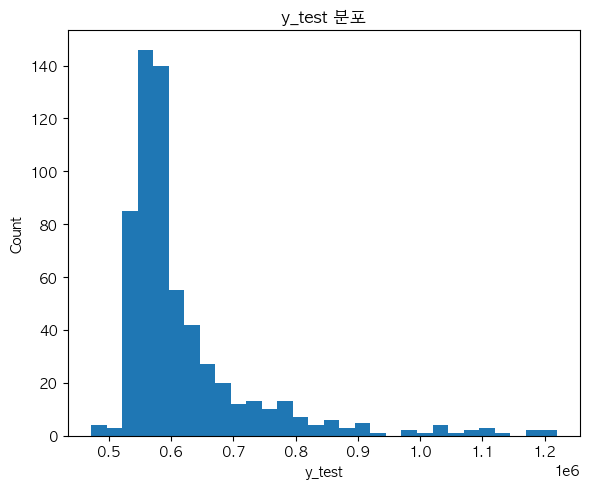

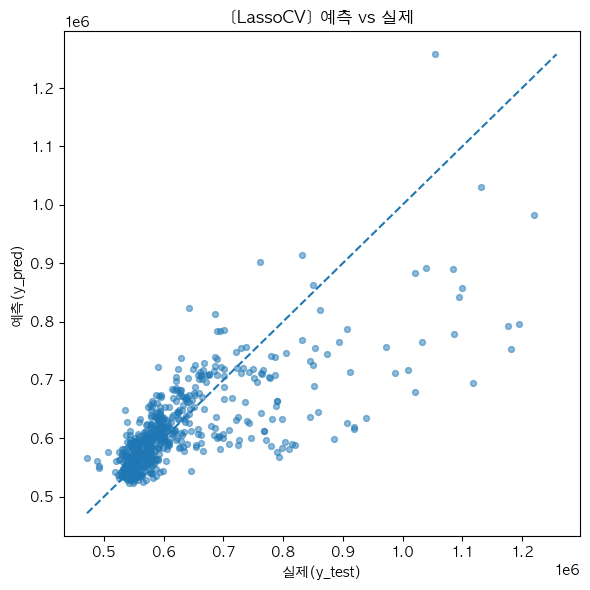

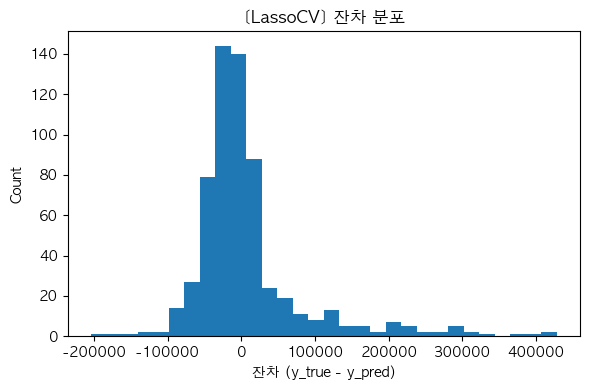

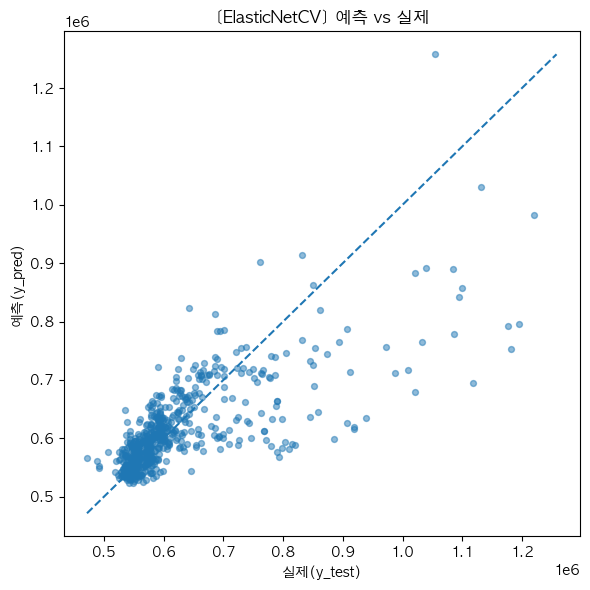

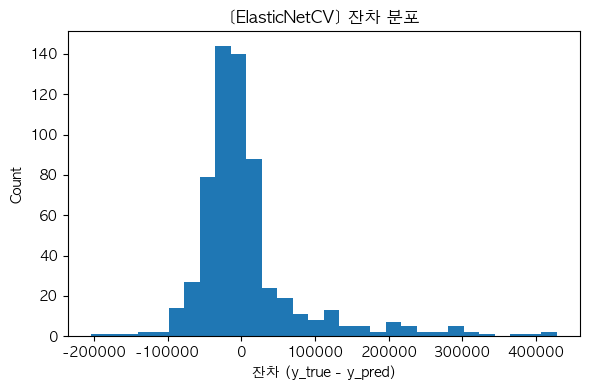

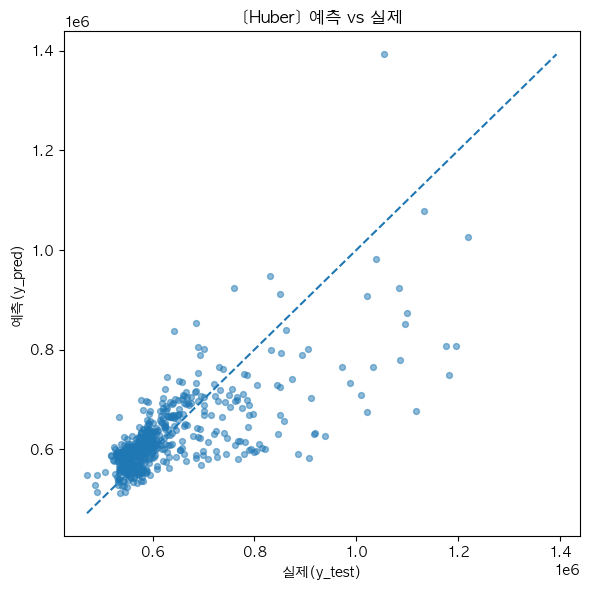

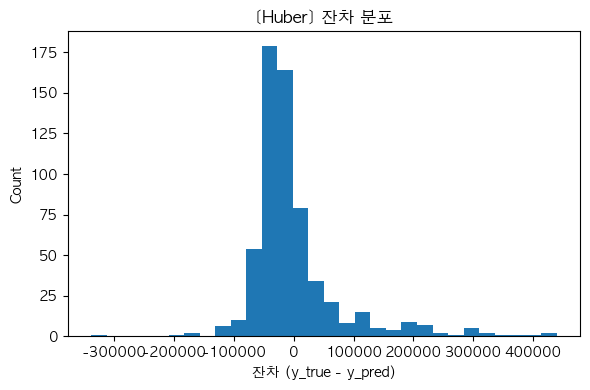

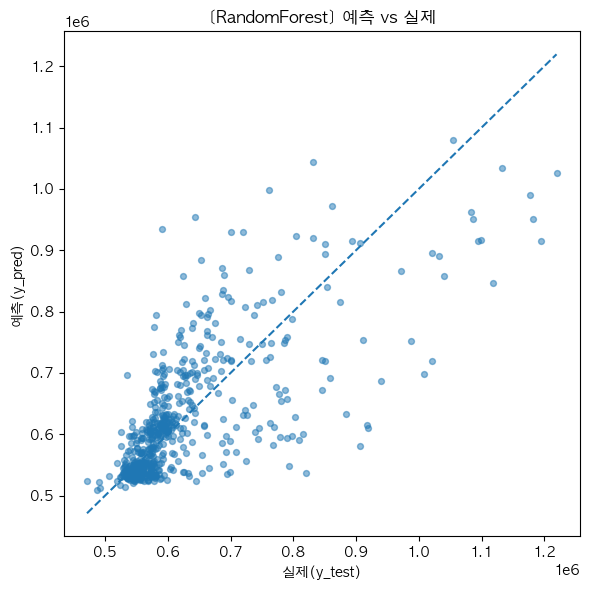

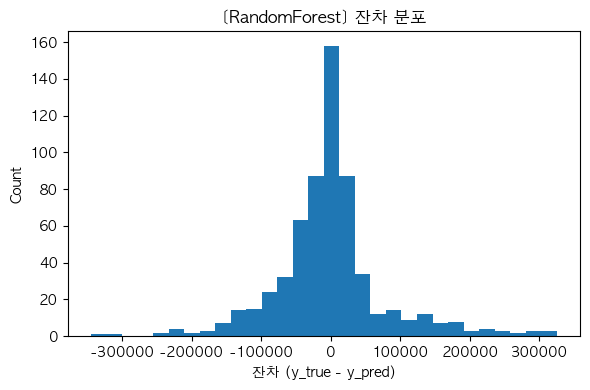

In [129]:
# 타깃 분포
plt.figure(figsize=(6,5))
plt.title("y_test 분포")
plt.hist(y_test, bins=30)
plt.xlabel("y_test")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 상위 N개 모델 시각화
topN = 4
top_models = eval_df.index[:topN].tolist()

for name in top_models:
    y_pred = pred_store[name]

    # 예측 vs 실제
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5, s=18)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims, linestyle='--')
    plt.title(f"[{name}] 예측 vs 실제")
    plt.xlabel("실제(y_test)")
    plt.ylabel("예측(y_pred)")
    plt.tight_layout()
    plt.show()

    # 잔차 분포
    residuals = y_test.values - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30)
    plt.title(f"[{name}] 잔차 분포")
    plt.xlabel("잔차 (y_true - y_pred)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


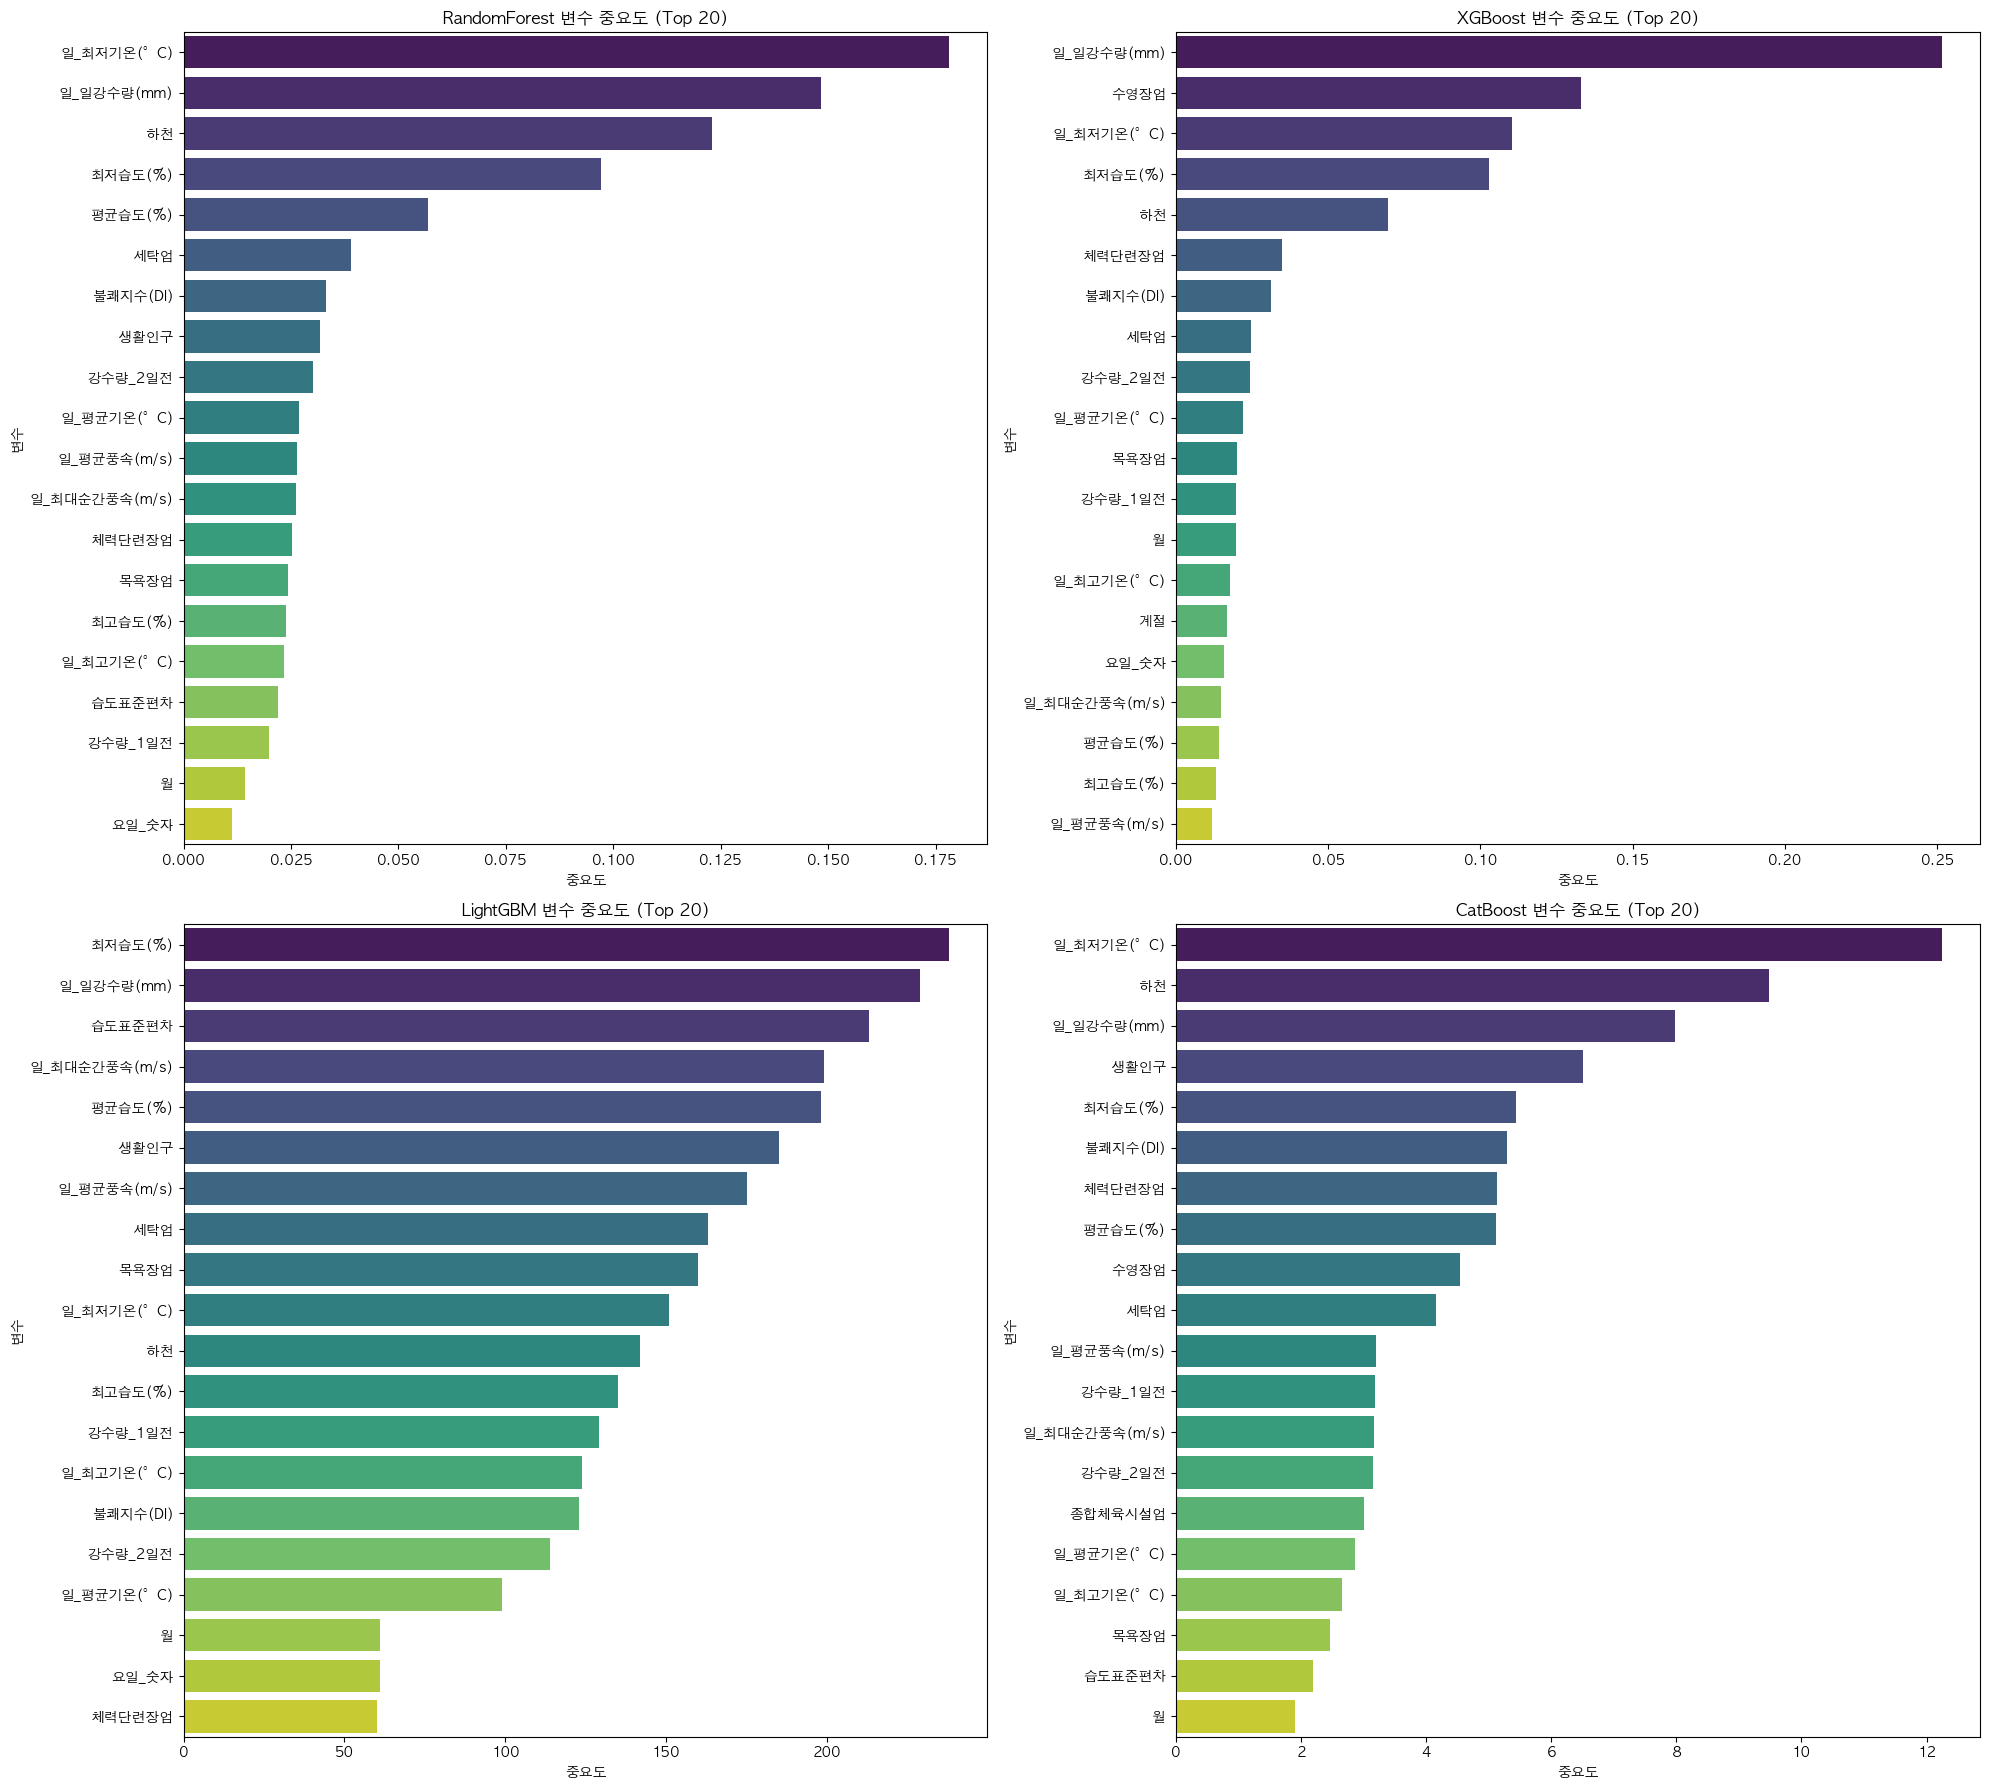

In [130]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))
axes = axes.flatten()
tree_names = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']

for i, name in enumerate(tree_names):
    ax = axes[i]
    model = models.get(name, None)
    if model is None:
        ax.axis('off'); ax.set_title(f"{name} 미정의"); continue

    if hasattr(model, 'feature_importances_'):
        imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
        sns.barplot(x=imp.values, y=imp.index, ax=ax, palette='viridis', hue=imp.index, legend=False)
        ax.set_title(f'{name} 변수 중요도 (Top 20)')
        ax.set_xlabel('중요도')
        ax.set_ylabel('변수')
    else:
        ax.axis('off'); ax.set_title(f"{name}: feature_importances_ 없음")

plt.tight_layout()
plt.show()



 트리 모델 SHAP 분석 시작...
RandomForest 모델 SHAP 분석 중...


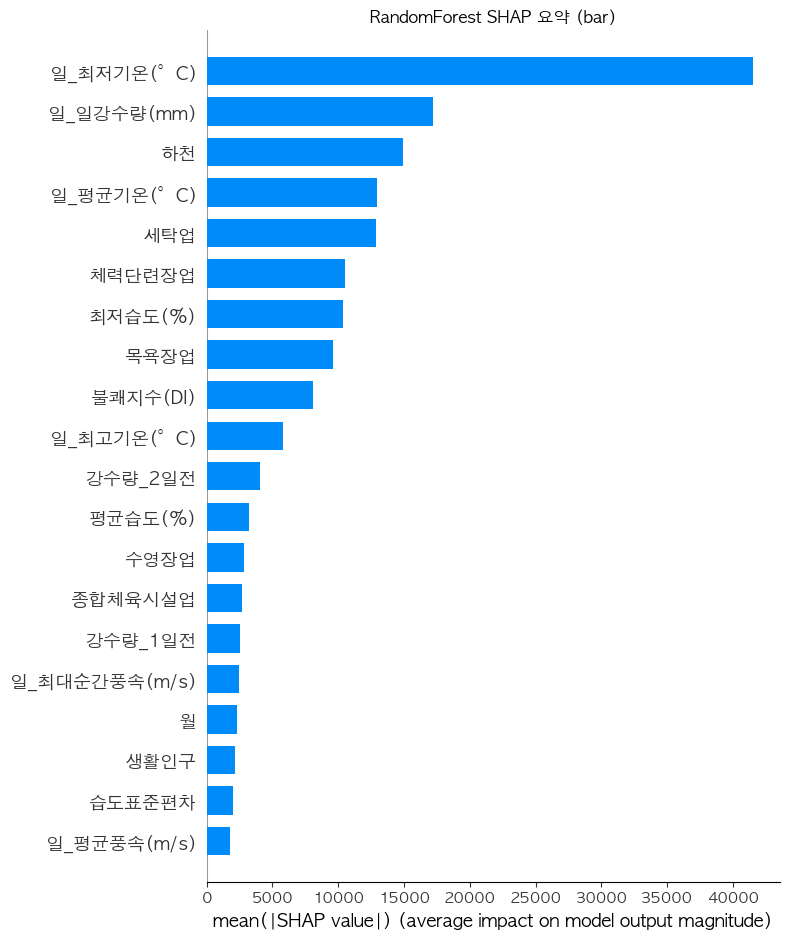

<Figure size 640x480 with 0 Axes>

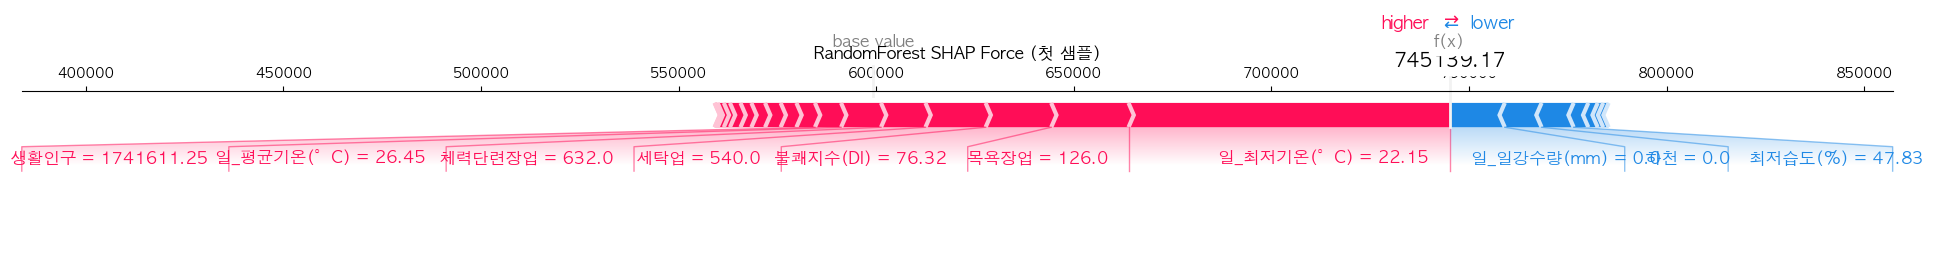

XGBoost 모델 SHAP 분석 중...


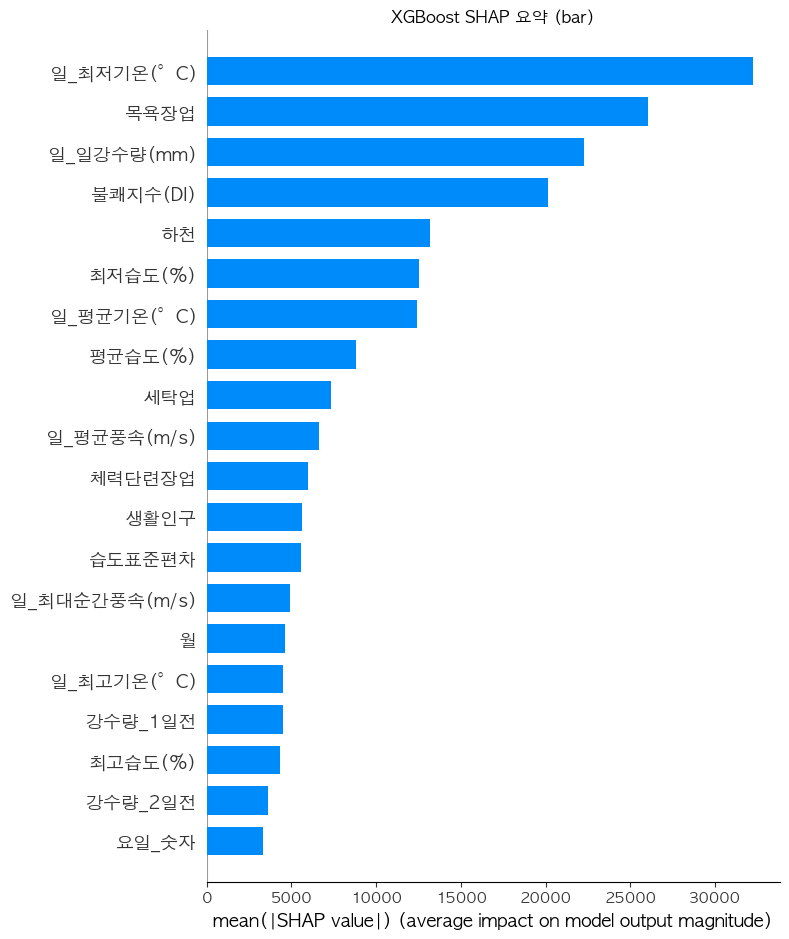

<Figure size 640x480 with 0 Axes>

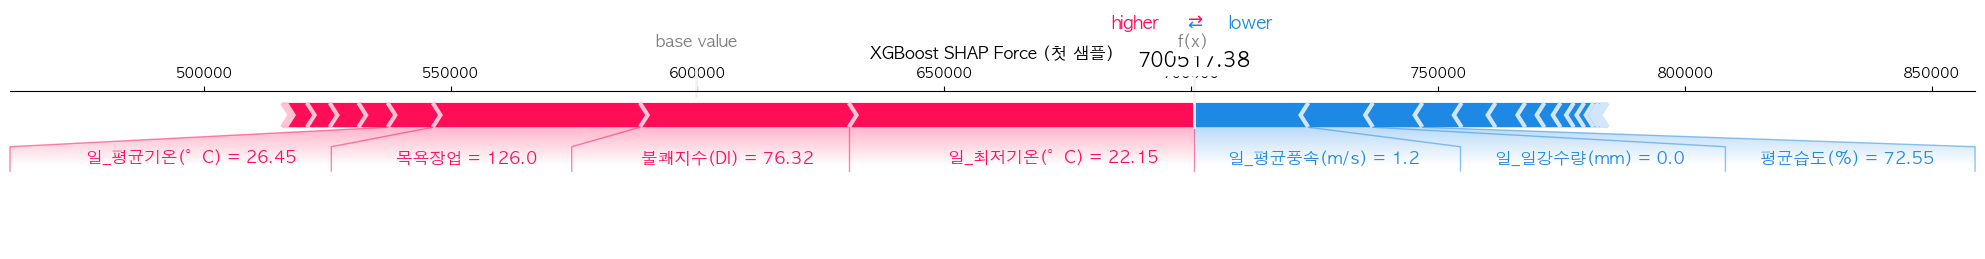

LightGBM 모델 SHAP 분석 중...


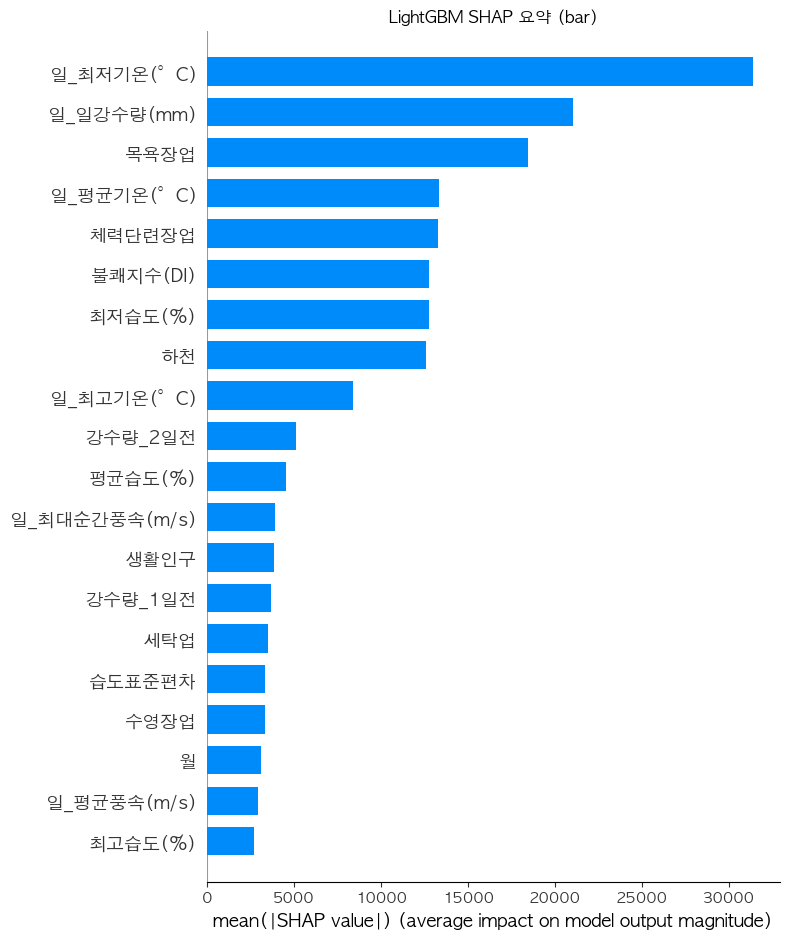

<Figure size 640x480 with 0 Axes>

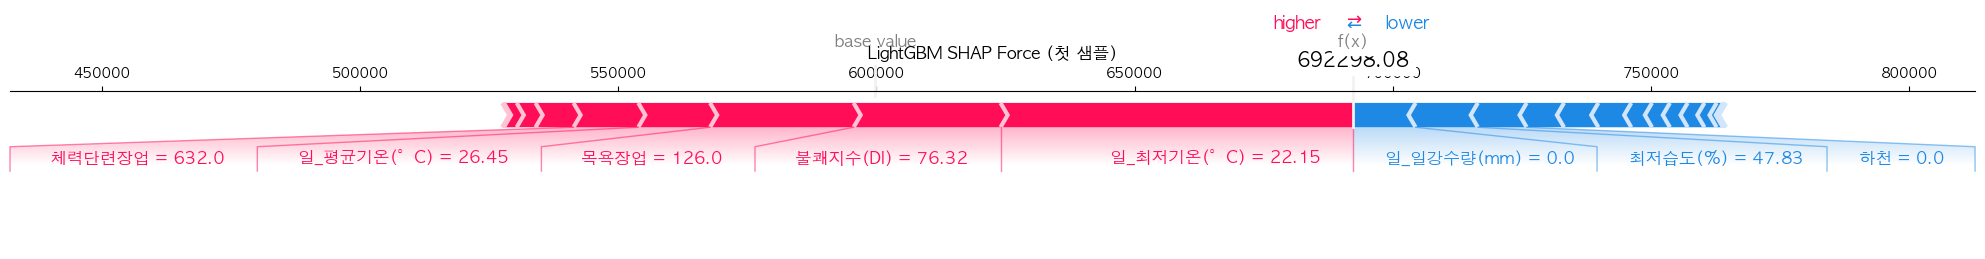

CatBoost 모델 SHAP 분석 중...


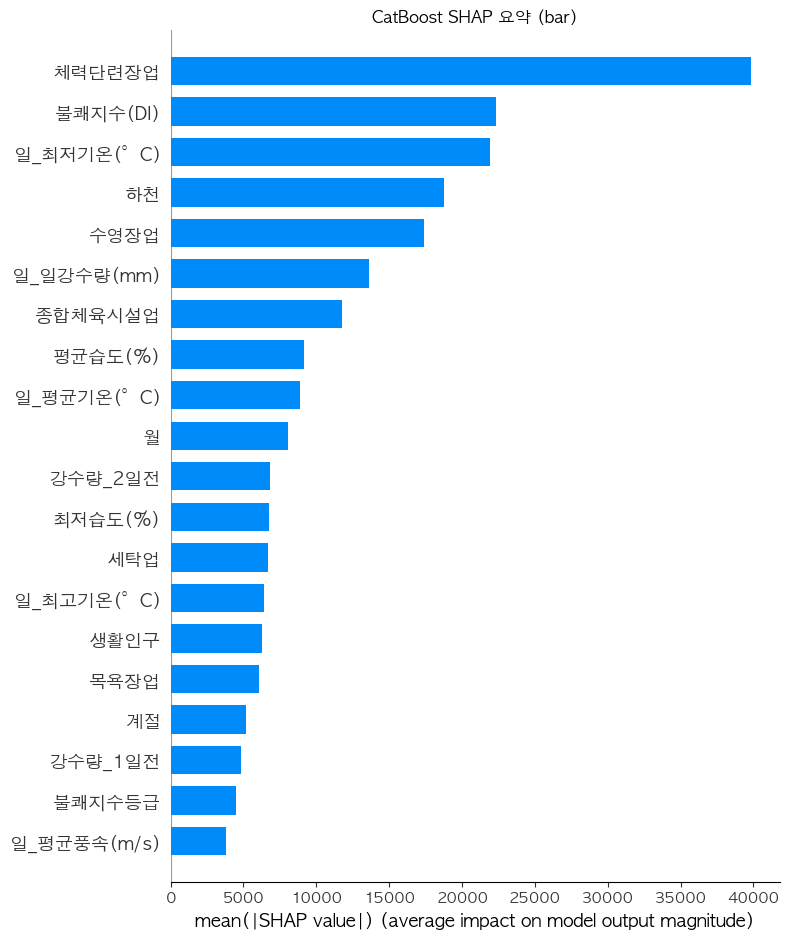

<Figure size 640x480 with 0 Axes>

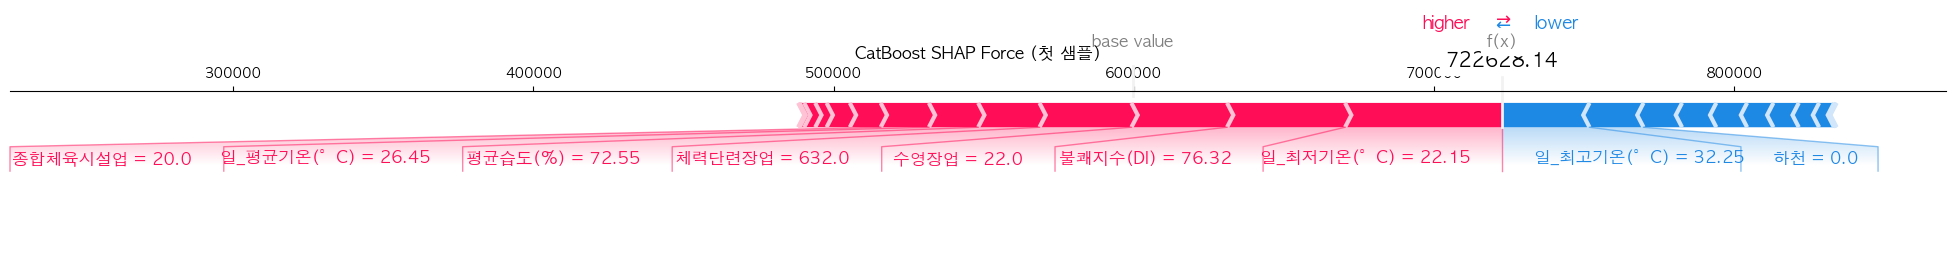

SHAP 분석 완료


In [131]:
print("\n 트리 모델 SHAP 분석 시작...")
# 테스트 데이터 샘플 수 제한 (연산량 절감용)
MAX_SAMPLES = 500
X_shap = X_test.copy()
if len(X_shap) > MAX_SAMPLES:
    X_shap = X_shap.sample(n=MAX_SAMPLES, random_state=42)

for name in tree_names:
    model = models.get(name, None)
    if model is None:
        continue

    try:
        print(f"{name} 모델 SHAP 분석 중...")
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_shap)

        # 요약 플롯 (bar)
        plt.figure()
        shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
        plt.title(f'{name} SHAP 요약 (bar)')
        plt.tight_layout()
        plt.show()

        # Force Plot (첫 샘플)
        try:
            plt.figure()
            shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap.iloc[0,:], matplotlib=True, show=False)
            plt.title(f'{name} SHAP Force (첫 샘플)')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"  Force Plot 생성 중 오류: {e}")

    except Exception as e:
        print(f"  {name} SHAP 분석 실패: {e}")

print("SHAP 분석 완료")


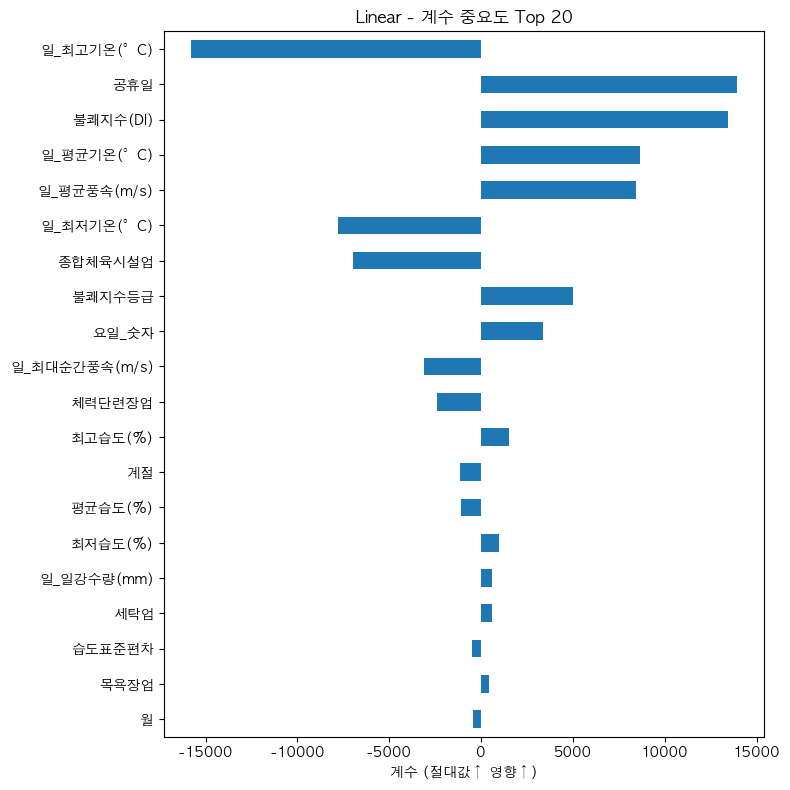

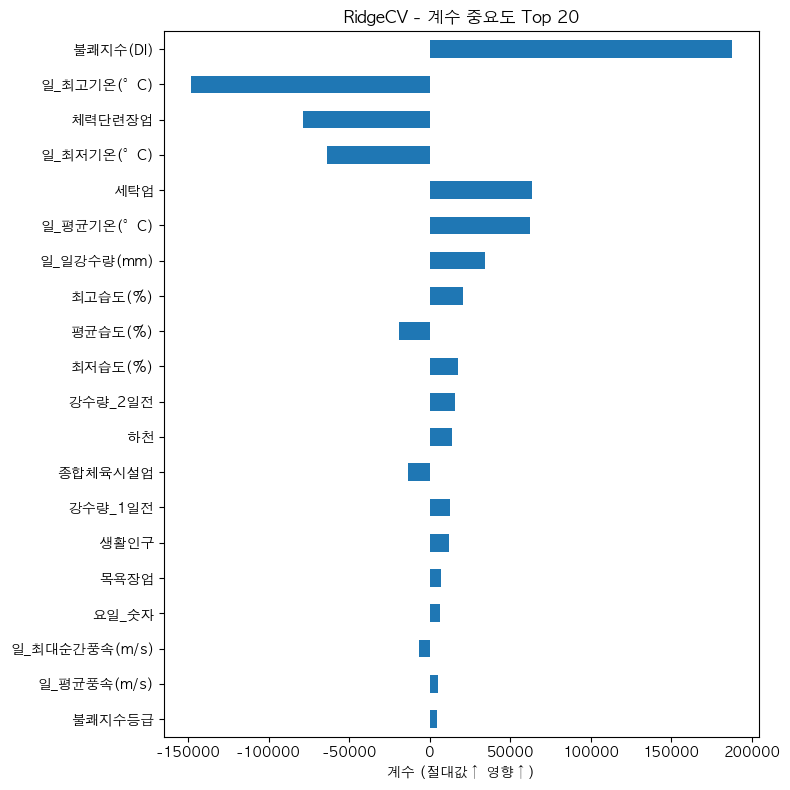

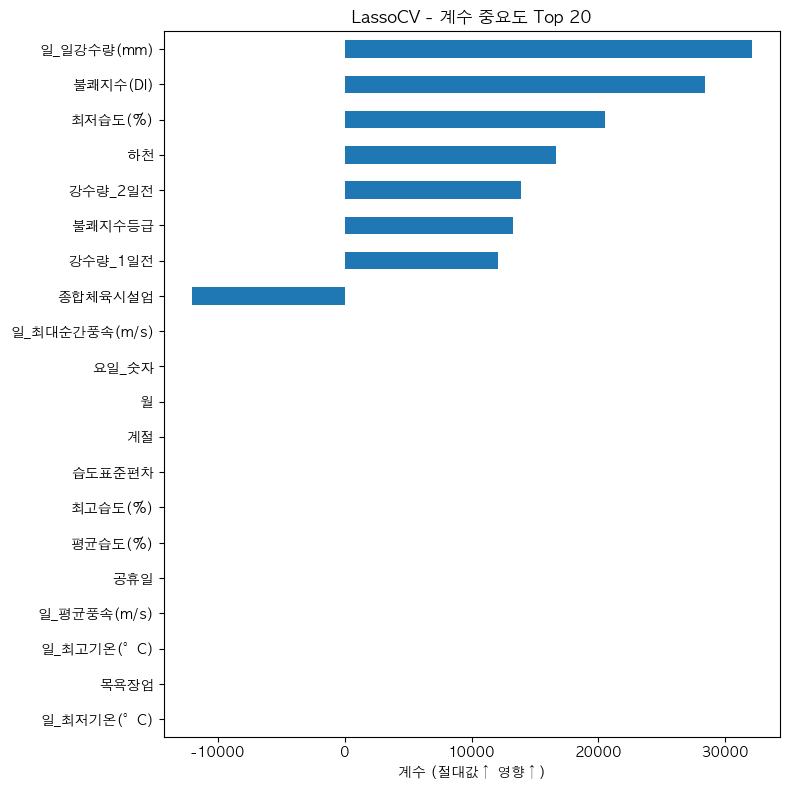

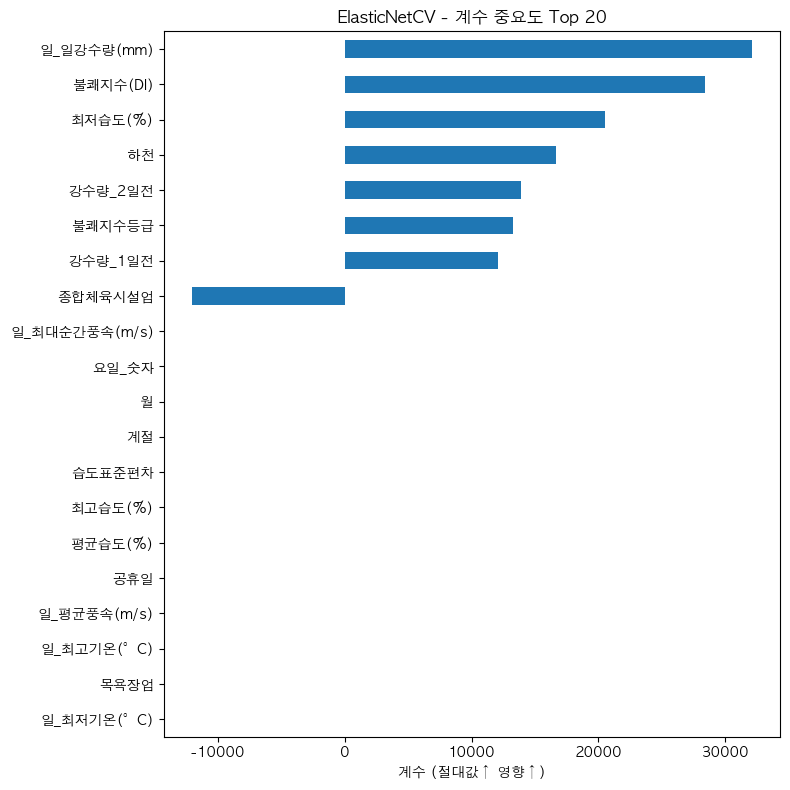

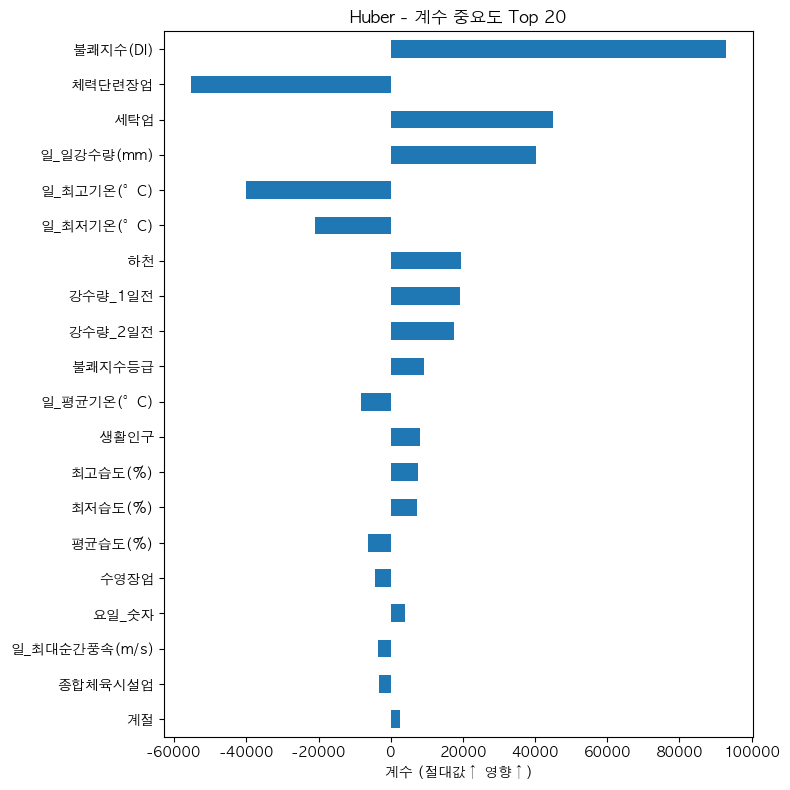

In [132]:
def plot_top_coefficients(model, feature_names, title, top_n=20):
    """
    Pipeline일 경우 마지막 스텝에서 coef_ 추출.
    coef_가 없는 모델(SVR, KNN, Dummy 등)은 건너뜀.
    """
    est = model
    if hasattr(est, 'named_steps'):
        est = list(est.named_steps.values())[-1]
    if not hasattr(est, 'coef_'):
        print(f"[{title}] coef_ 없음 → 건너뜀")
        return

    coefs = np.ravel(est.coef_)
    coef_ser = pd.Series(coefs, index=feature_names).sort_values(key=np.abs, ascending=False).head(top_n)

    plt.figure(figsize=(8, max(5, int(top_n*0.4))))
    coef_ser.iloc[::-1].plot(kind='barh')
    plt.title(f"{title} - 계수 중요도 Top {top_n}")
    plt.xlabel("계수 (절대값↑ 영향↑)")
    plt.tight_layout()
    plt.show()

for name in ['Linear', 'RidgeCV', 'LassoCV', 'ElasticNetCV', 'Huber']:
    if name in models:
        plot_top_coefficients(models[name], X_train.columns, title=name, top_n=20)


In [133]:
if 'CatBoost' in models:
    print("\n--- 🌟 CatBoost 중요도 기반 Top 25 피처 선택 ---")
    selector_model = models['CatBoost']
    importances = pd.Series(selector_model.feature_importances_, index=X_train.columns)
    top_n_features = importances.sort_values(ascending=False).head(25).index.tolist()
    print(top_n_features)

    X_train_sel = X_train[top_n_features]
    X_test_sel  = X_test[top_n_features]

    evaluation_results_selected = []
    for name in tree_names:
        if name not in models:
            continue
        print(f"🚀 {name} (Top25 피처) 재학습 중...")
        mdl = models[name]
        mdl.fit(X_train_sel, y_train)
        y_pred = mdl.predict(X_test_sel)
        r2 = r2_score(y_test, y_pred)
        evaluation_results_selected.append({'Model': name, 'R2 (Top25)': r2})

    eval_df_selected = pd.DataFrame(evaluation_results_selected).set_index('Model')
    print("\n📊 피처 선택 후 트리 모델 R2:")
    display(eval_df_selected)
else:
    print("CatBoost 모델이 없어 피처 선택 스킵.")



--- 🌟 CatBoost 중요도 기반 Top 25 피처 선택 ---
['일_최저기온(°C)', '하천', '일_일강수량(mm)', '생활인구', '최저습도(%)', '불쾌지수(DI)', '체력단련장업', '평균습도(%)', '수영장업', '세탁업', '일_평균풍속(m/s)', '강수량_1일전', '일_최대순간풍속(m/s)', '강수량_2일전', '종합체육시설업', '일_평균기온(°C)', '일_최고기온(°C)', '목욕장업', '습도표준편차', '월', '최고습도(%)', '요일_숫자', '불쾌지수등급', '계절', '공휴일']
🚀 RandomForest (Top25 피처) 재학습 중...
🚀 XGBoost (Top25 피처) 재학습 중...
🚀 LightGBM (Top25 피처) 재학습 중...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 2455, number of used features: 25
[LightGBM] [Info] Start training from score 599771.223040
🚀 CatBoost (Top25 피처) 재학습 중...

📊 피처 선택 후 트리 모델 R2:


,R2 (Top25)
Model,
RandomForest,0.491549
XGBoost,0.411903
LightGBM,0.486866
CatBoost,0.424706


In [134]:
# %% [markdown]
# ## 9. (옵션) 결과 저장
# - 테이블/그림 저장이 필요하면 아래 주석을 해제하세요.
# %%
# eval_df.to_csv('all_models_evaluation.csv', encoding='utf-8-sig')
# plt.savefig('feature_importances_ALL_final.png')  # 변수중요도 그리면 그 때 저장
# SHAP 그림은 위 셀에서 바로 show 했습니다. 저장하려면 summary_plot에 show=False 후 savefig 호출 추가하세요.


### GPT 새기 ###

In [135]:
# %% [markdown]
# # TimeSeriesSplit CV + RF/XGB/CatBoost/LGBM + FI/Permutation Importance/SHAP/LIME
# - RMSE 버전 의존성 문제 해결 (수동 RMSE)
# - 모델별 CV 성능 비교
# - 모델별 Feature Importance
# - Best 모델에 대해 Permutation Importance
# - SHAP, LIME 단일 샘플 설명 (선택적으로 실행)

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor

# xgboost / catboost / lightgbm은 설치 여부에 따라 다를 수 있음 → try/except로 안전 처리
has_xgb = has_cat = has_lgbm = True
try:
    from xgboost import XGBRegressor
except Exception as e:
    has_xgb = False
    print("[WARN] xgboost 미설치 또는 임포트 실패:", e)

try:
    from catboost import CatBoostRegressor
except Exception as e:
    has_cat = False
    print("[WARN] catboost 미설치 또는 임포트 실패:", e)

try:
    from lightgbm import LGBMRegressor
except Exception as e:
    has_lgbm = False
    print("[WARN] lightgbm 미설치 또는 임포트 실패:", e)

# -------------------------
# 0) X, y 구성 (이미 nanji 구축/전처리 끝난 상태 가정)
#    not_use_col은 사용자가 정의한 리스트를 그대로 활용
# -------------------------
not_use_col = [
    '날짜', '요일',
    '1처리장', '2처리장', '정화조', '중계펌프장', '합계',
    '일_일강수량(mm)', '생활인구',
    '합계_1일후','합계_2일후'
]

# 존재하는 컬럼만 feature로 사용
feature_cols = [c for c in nanji.columns if c not in not_use_col]
df_model = nanji.dropna(subset=['합계_1일후']).reset_index(drop=True)

X = df_model[feature_cols].copy()
y = df_model['합계_1일후'].copy()

print(f"[INFO] X.shape={X.shape}, y.shape={y.shape}")
print(f"[INFO] 기간: {df_model['날짜'].min().date()} ~ {df_model['날짜'].max().date()}")

# -------------------------
# 1) TimeSeriesSplit
# -------------------------
tscv = TimeSeriesSplit(n_splits=5)

def rmse(y_true, y_pred):
    # 버전 무관하게 동작하는 RMSE 계산
    return float(np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2)))

# -------------------------
# 2) 모델 정의
# -------------------------
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=400, max_depth=None, random_state=42, n_jobs=-1
    )
}

if has_xgb:
    models["XGB"] = XGBRegressor(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1,
        objective="reg:squarederror",  # 명시적으로 설정
        eval_metric="rmse"             # 경고 억제
    )

if has_cat:
    models["CatBoost"] = CatBoostRegressor(
        iterations=700, depth=6, learning_rate=0.05,
        random_state=42, verbose=0, loss_function='RMSE'
    )

if has_lgbm:
    models["LGBM"] = LGBMRegressor(
        n_estimators=700, max_depth=-1, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )

# -------------------------
# 3) CV 학습 + 평가
# -------------------------
cv_scores = {}
fold_predictions = {}   # 필요시 예측 보관
fitted_models = {}      # 마지막 fold의 학습 모델 보관(중요도/SHAP에 사용)

for name, model in models.items():
    rmses = []
    preds_all = []
    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_va)
        score = rmse(y_va, y_hat)
        rmses.append(score)

        preds_all.append(pd.DataFrame({
            "idx": va_idx,
            "y": y_va.values,
            "y_hat": y_hat
        }))
        print(f"[{name}] Fold {fold} RMSE = {score:,.0f}")

    cv_scores[name] = (np.mean(rmses), np.std(rmses))
    fold_predictions[name] = pd.concat(preds_all).sort_values("idx").reset_index(drop=True)
    fitted_models[name] = model
    print(f"[{name}] CV RMSE = {np.mean(rmses):,.0f} ± {np.std(rmses):,.0f}\n")

print("=== Summary (CV RMSE) ===")
for k, (m, s) in cv_scores.items():
    print(f"{k:<12} {m:,.0f} ± {s:,.0f}")


[INFO] X.shape=(3069, 23), y.shape=(3069,)
[INFO] 기간: 2017-01-03 ~ 2025-05-29
[RandomForest] Fold 1 RMSE = 140,354
[RandomForest] Fold 2 RMSE = 79,701
[RandomForest] Fold 3 RMSE = 104,232
[RandomForest] Fold 4 RMSE = 118,337
[RandomForest] Fold 5 RMSE = 79,812
[RandomForest] CV RMSE = 104,487 ± 23,244

[XGB] Fold 1 RMSE = 142,703
[XGB] Fold 2 RMSE = 78,966
[XGB] Fold 3 RMSE = 110,823
[XGB] Fold 4 RMSE = 112,375
[XGB] Fold 5 RMSE = 80,269
[XGB] CV RMSE = 105,027 ± 23,661

[CatBoost] Fold 1 RMSE = 100,515
[CatBoost] Fold 2 RMSE = 79,868
[CatBoost] Fold 3 RMSE = 106,823
[CatBoost] Fold 4 RMSE = 112,688
[CatBoost] Fold 5 RMSE = 82,572
[CatBoost] CV RMSE = 96,493 ± 13,080

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 514, 

In [136]:
너는 실력 좋은 데이터분석가이자 데이터사이언티스트야. 파이썬 코드를 줄 때는 .ipynb(파이썬) 파일 형식으로 항상 알려줘. 그리고 모든 코드에 주석을 달아서 설명해줘.
내가 요구하기 전까지는 파일로 주지 말고 먼저 채팅창에 보내줘

SyntaxError: invalid syntax (1453579393.py, line 1)

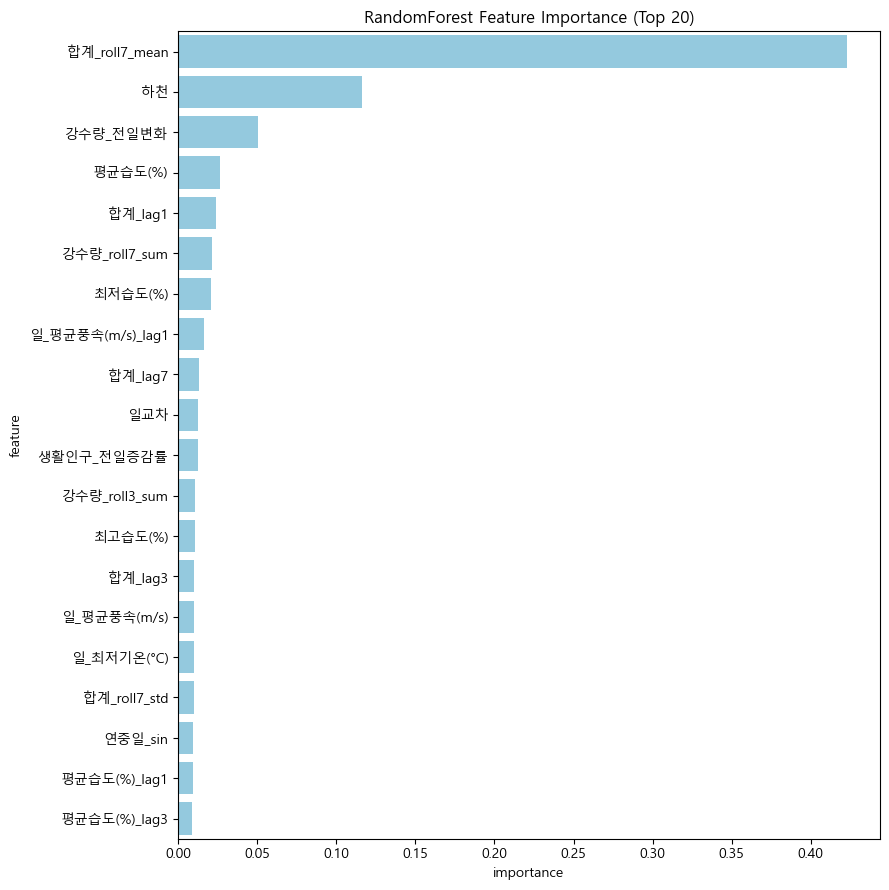

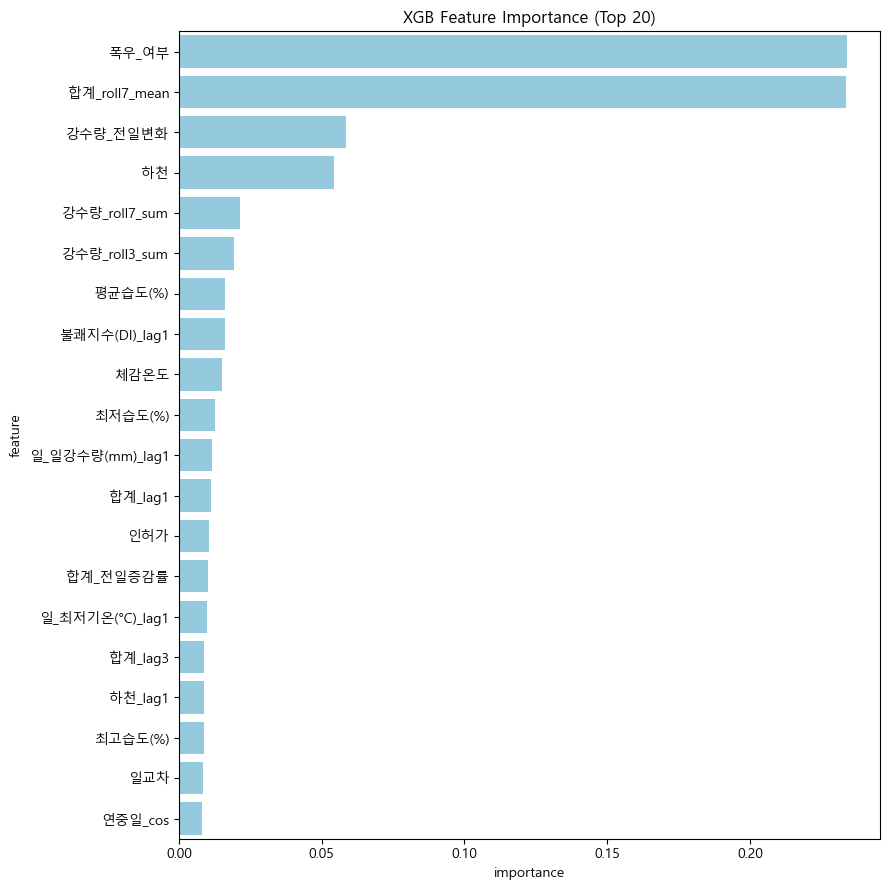

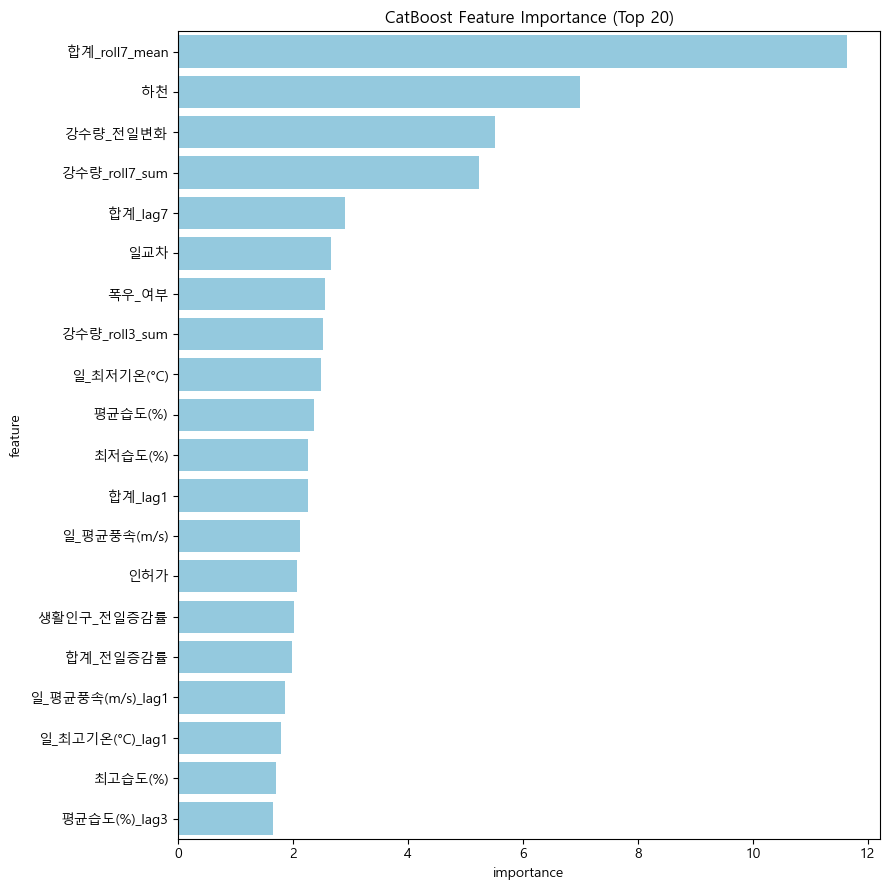

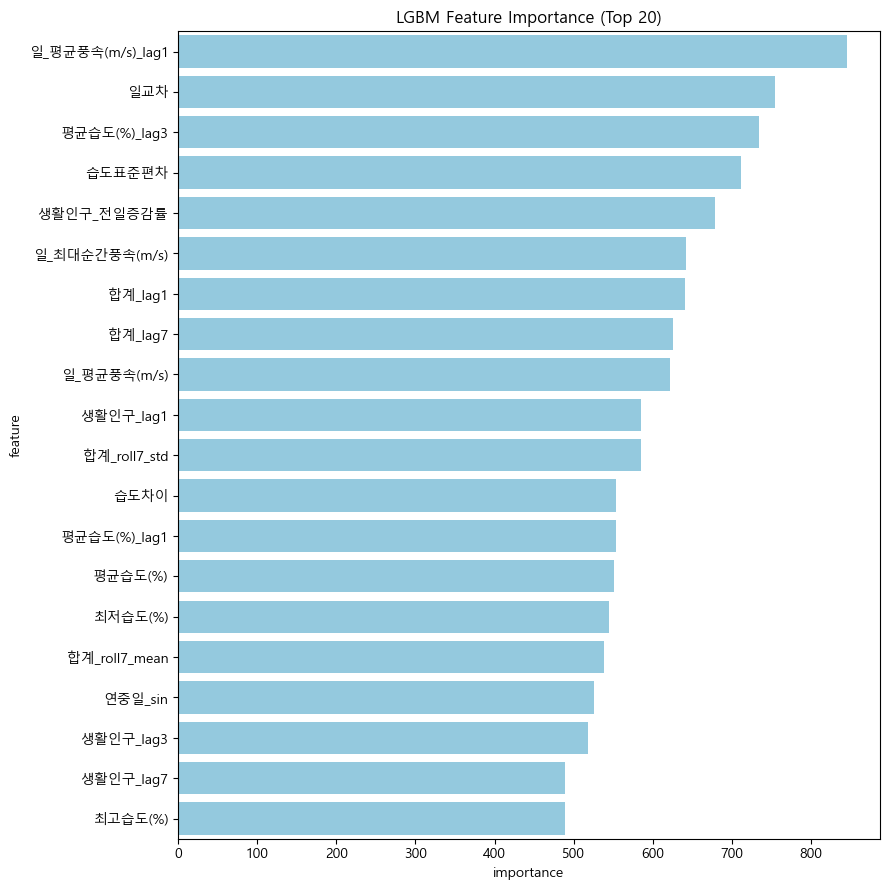

In [ ]:
# %% [markdown]
# ## 4) 모델별 Feature Importance (내장) 시각화
# - Tree 계열: feature_importances_ 사용 가능
# - CatBoost도 .get_feature_importance() 제공
# - seaborn 경고 피하려고 단색(color) 사용

# %%
def plot_feature_importance(model, X, title, topn=20):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
    elif "CatBoost" in model.__class__.__name__:
        try:
            imp = model.get_feature_importance()
        except:
            print("[WARN] CatBoost 중요도 추출 실패")
            return
    else:
        print("[WARN] 이 모델은 내장 중요도가 없습니다:", model.__class__.__name__)
        return

    fi = (pd.DataFrame({"feature": X.columns, "importance": imp})
          .sort_values("importance", ascending=False))

    plt.figure(figsize=(9, 0.45*min(topn, len(fi))))
    sns.barplot(data=fi.head(topn), x="importance", y="feature", color="skyblue")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for name, model in fitted_models.items():
    plot_feature_importance(model, X, f"{name} Feature Importance (Top 20)", topn=20)


[INFO] Best model by CV: CatBoost


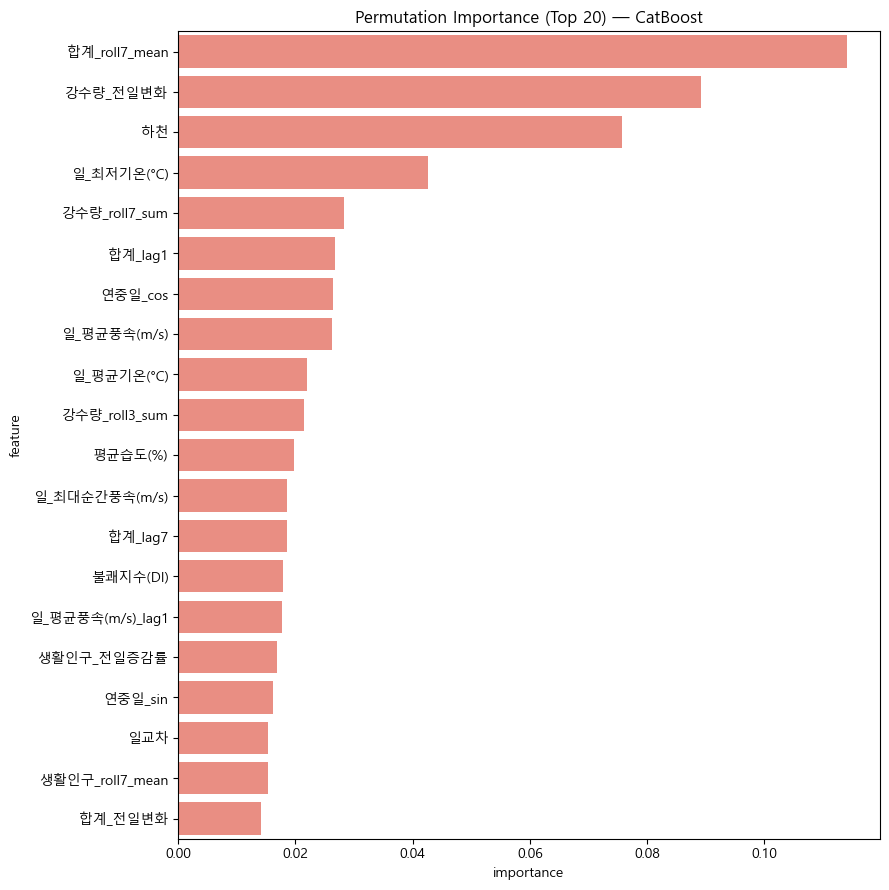

,feature,importance,std
46,합계_roll7_mean,0.114040,0.003475
54,강수량_전일변화,0.089160,0.003234
6,하천,0.075657,0.002396
9,일_최저기온(°C),0.042679,0.000974
50,강수량_roll7_sum,0.028317,0.000983
38,합계_lag1,0.026726,0.001048
24,연중일_cos,0.026480,0.001088
12,일_평균풍속(m/s),0.026217,0.001055
10,일_평균기온(°C),0.021963,0.000785
49,강수량_roll3_sum,0.021470,0.000939


In [ ]:
# %% [markdown]
# ## 5) Permutation Importance (Best 모델 기준)
# - CV 성능이 가장 좋은 모델 하나를 골라 전체 데이터에 적합 후 Permutation Importance 계산
# - n_repeats는 상황에 따라 늘릴 수 있음 (시간 증가)

# %%
best_name = min(cv_scores, key=lambda k: cv_scores[k][0])  # RMSE 평균 최소 모델 선택
best_model = models[best_name]
print(f"[INFO] Best model by CV: {best_name}")

# 전체 데이터 적합(설명용)
best_model.fit(X, y)

perm = permutation_importance(best_model, X, y, n_repeats=8, random_state=42)

perm_df = (pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False))

plt.figure(figsize=(9, 0.45*min(20, len(perm_df))))
sns.barplot(data=perm_df.head(20), x="importance", y="feature", color="salmon")
plt.title(f"Permutation Importance (Top 20) — {best_name}")
plt.tight_layout()
plt.show()

perm_df.head(20)


c:\Users\user\anaconda3\envs\young\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


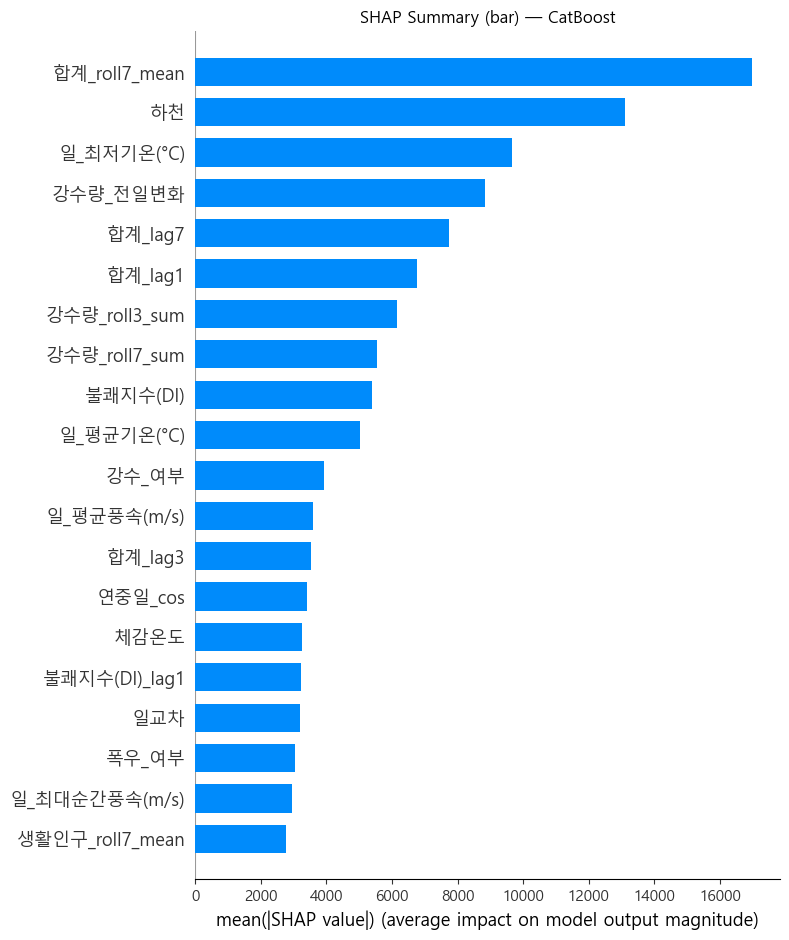

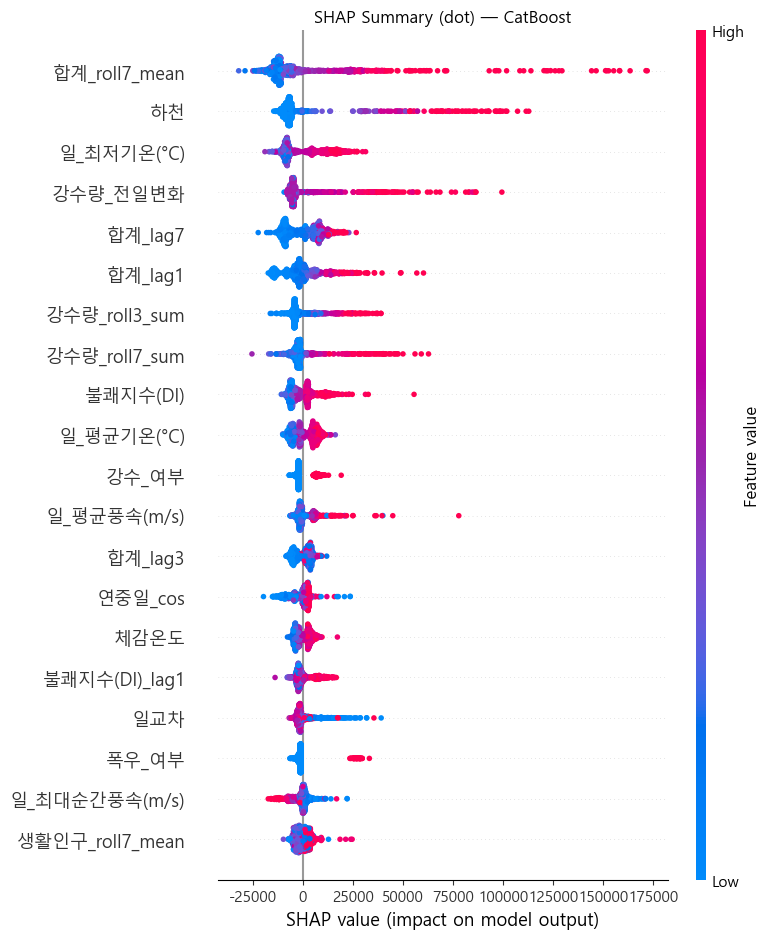

In [ ]:
# %% [markdown]
# ## 6) SHAP (선택) — Tree 계열 모델에 적합
# - 설치 필요: shap
# - 해석: summary_plot(bar) = 전반적 중요도, summary_plot(dot) = 영향 방향/분포
# - 데이터가 크면 샘플링 사용 권장

# %%
try:
    import shap
    shap.initjs()

    # TreeExplainer는 트리 계열에 최적화 (RF/XGB/LGBM/CatBoost)
    explainer = shap.TreeExplainer(best_model)
    # 계산량 줄이기 위해 일부 샘플만 (예: 1000개)
    nsample = min(1000, len(X))
    X_sample = X.sample(nsample, random_state=42)

    shap_values = explainer.shap_values(X_sample)

    # 전반적 중요도 (bar)
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title(f"SHAP Summary (bar) — {best_name}")
    plt.tight_layout()
    plt.show()

    # 영향 방향/분포 (dot)
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f"SHAP Summary (dot) — {best_name}")
    plt.tight_layout()
    plt.show()

    # 단일 샘플 force_plot (노트북에서만 인터랙티브)
    one_idx = X_sample.index[0]
    shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0,:])
except Exception as e:
    print("[WARN] SHAP 실행 건너뜀:", e)


In [ ]:
# %% [markdown]
# ## 7) LIME (선택) — 단일 예측에 대한 지역적 설명
# - 설치 필요: lime
# - 수치형 전처리 없이도 동작하지만, 스케일이 매우 다르면 표준화 후 사용하는 것을 권장

# %%
try:
    from lime.lime_tabular import LimeTabularExplainer

    # 훈련 데이터 기반으로 LIME 설명자 생성
    explainer = LimeTabularExplainer(
        training_data=np.array(X),
        feature_names=X.columns.tolist(),
        mode='regression',
        discretize_continuous=False  # 연속형 그대로
    )

    # 임의의 샘플 1개 선택
    i = np.random.randint(0, len(X))
    x_i = np.array(X.iloc[i])
    exp = explainer.explain_instance(
        data_row=x_i,
        predict_fn=best_model.predict,
        num_features=10
    )
    # 노트북에서는 exp.show_in_notebook() 가능
    print("[LIME] sample index:", i)
    for feat, weight in exp.as_list():
        print(f"{feat:60s} {weight:+.4f}")

except Exception as e:
    print("[WARN] LIME 실행 건너뜀:", e)


[LIME] sample index: 612
하천                                                           +22540.3167
일_평균풍속(m/s)_lag1                                             -12069.7535
일_평균기온(°C)                                                   +9166.4382
일_최저기온(°C)                                                   +8754.3028
연중일_sin                                                      +6298.8285
불쾌지수(DI)                                                     +5394.9812
일_최고기온(°C)_lag3                                              -4334.8143
체감온도                                                         +4157.2550
체력단련장업                                                       -3141.7246
생활인구_lag7                                                    -2493.7888


In [ ]:
# %% [markdown]
# ## 1) 학습 데이터셋(X, y) 구성
# - 타깃: 합계_1일후 (shift(-1))
# - 피처: 오늘까지 정보 + 순환 인코딩 + 라그/롤링 + 이벤트/인허가
# - dropna로 라그/롤링 초반 결측 제거

# %%
target = '합계_1일후'
feature_cols = [
    # 계절성(순환)
    '월_sin','월_cos','요일_sin','요일_cos','연중일_sin','연중일_cos',
    # 자기상관/지연
    '합계_lag1','합계_lag3','합계_lag7',
    '생활인구_lag1','생활인구_lag3','생활인구_lag7',
    '일_일강수량(mm)_lag1','일_일강수량(mm)_lag3',
    # 롤링(오늘까지)
    '합계_roll7_mean','합계_roll7_std',
    '생활인구_roll7_mean',
    '강수량_roll3_sum','강수량_roll7_sum',
    # 변화/이벤트/날씨
    '합계_전일증감률','합계_전일변화','생활인구_전일증감률','강수량_전일변화',
    '일교차','체감온도','습도차이','강수_여부','폭우_여부','폭염일','한파_여부',
    # 느린 추세
    '인허가','인허가_누적',
    # 보강용 정수형 계절/쾌적도(순환과 함께 쓰되, 트리 모델이면 문제 없음)
    '계절','불쾌지수등급'
]

# 실제 존재하는 컬럼만 사용(안전)
feature_cols = [c for c in feature_cols if c in nanji.columns]

df_model = nanji[['날짜', target] + feature_cols].dropna().reset_index(drop=True)
X = df_model[feature_cols].copy()
y = df_model[target].copy()

print("[INFO] X, y shape:", X.shape, y.shape)
print("[INFO] 기간:", df_model['날짜'].min(), "→", df_model['날짜'].max())


[INFO] X, y shape: (3064, 33) (3064,)
[INFO] 기간: 2017-01-08 00:00:00 → 2025-05-29 00:00:00


In [ ]:
# %% [markdown]
# ## 2) 시계열 분할 학습/평가 (Baseline: RandomForest)
# - shuffle=False
# - RMSE/MAE 출력
# - 중요도(내장) + Permutation Importance

# %%
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tscv = TimeSeriesSplit(n_splits=5)
rmse_list, mae_list = [], []

rf_models = []  # 추후 SHAP 등 쓰고 싶으면 보관

for fold, (tr_idx, te_idx) in enumerate(tscv.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    pred = rf.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, pred))
    mae  = mean_absolute_error(y_te, pred)
    rmse_list.append(rmse); mae_list.append(mae)
    rf_models.append(rf)
    print(f"[Fold {fold}] RMSE={rmse:,.0f} | MAE={mae:,.0f}")

print(f"\n[CV] RMSE: {np.mean(rmse_list):,.0f} ± {np.std(rmse_list):,.0f}")
print(f"[CV] MAE : {np.mean(mae_list):,.0f} ± {np.std(mae_list):,.0f}")


[Fold 1] RMSE=110,222 | MAE=83,476
[Fold 2] RMSE=79,794 | MAE=50,268
[Fold 3] RMSE=89,416 | MAE=62,995
[Fold 4] RMSE=108,798 | MAE=69,615
[Fold 5] RMSE=74,297 | MAE=48,818

[CV] RMSE: 92,505 ± 14,711
[CV] MAE : 63,035 ± 12,855


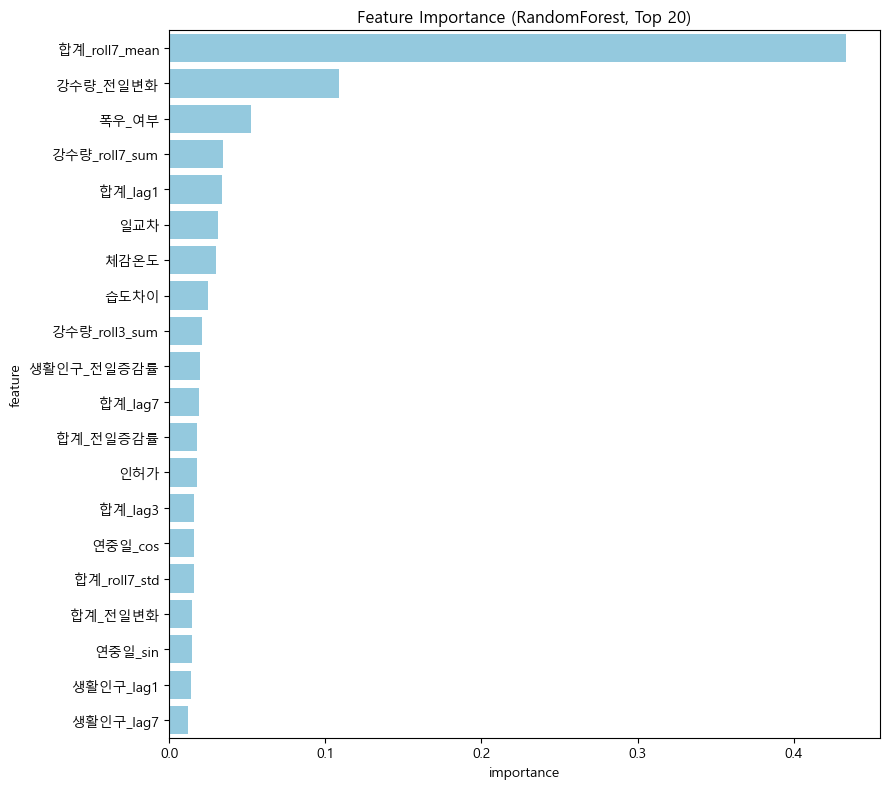

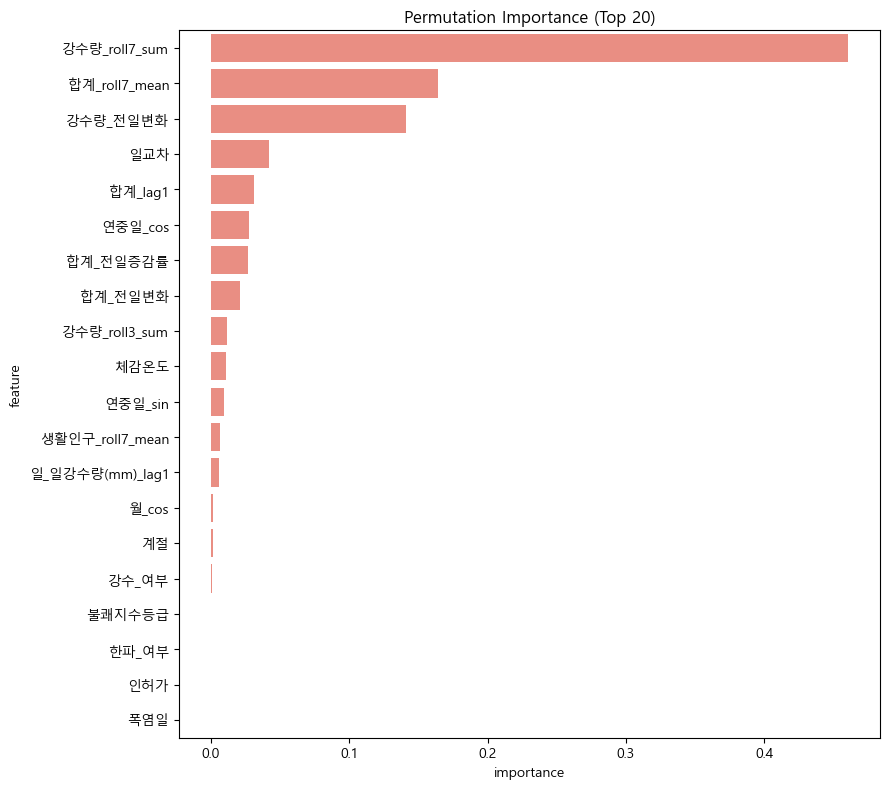

In [ ]:
# %% [markdown]
# ## 3) Feature Importance (내장) + Permutation Importance
# - seaborn 0.14 경고 피하기 위해 hue 지정 또는 단색 사용

# %%
# (a) 내장 feature_importances_ (마지막 fold 모델 예시)
rf_last = rf_models[-1]
fi = (
    pd.DataFrame({'feature': X.columns, 'importance': rf_last.feature_importances_})
    .sort_values('importance', ascending=False)
)

plt.figure(figsize=(9,8))
sns.barplot(data=fi.head(20), x='importance', y='feature', color='skyblue')
plt.title("Feature Importance (RandomForest, Top 20)")
plt.tight_layout()
plt.show()

# (b) Permutation Importance (마지막 fold의 테스트 세트 기준)
#   - 더 직관적: 해당 feature를 섞으면 성능이 얼마나 떨어지나?
X_tr, X_te = X.iloc[tscv.split(X).__next__()[0]], X.iloc[tscv.split(X).__next__()[1]]  # 첫 fold 재구성용
y_tr, y_te = y.iloc[tscv.split(X).__next__()[0]], y.iloc[tscv.split(X).__next__()[1]]

rf_last.fit(X_tr, y_tr)
perm = permutation_importance(rf_last, X_te, y_te, n_repeats=10, random_state=42)
perm_df = (
    pd.DataFrame({'feature': X.columns, 'importance': perm.importances_mean})
    .sort_values('importance', ascending=False)
)

plt.figure(figsize=(9,8))
sns.barplot(data=perm_df.head(20), x='importance', y='feature', color='salmon')
plt.title("Permutation Importance (Top 20)")
plt.tight_layout()
plt.show()
